# 第5章: 係り受け解析
夏目漱石の小説『吾輩は猫である』の文章（neko.txt）をCaboChaを使って係り受け解析し，その結果をneko.txt.cabochaというファイルに保存せよ．このファイルを用いて，以下の問に対応するプログラムを実装せよ．

## 40. 係り受け解析結果の読み込み（形態素）
形態素を表すクラスMorphを実装せよ．このクラスは表層形（surface），基本形（base），品詞（pos），品詞細分類1（pos1）をメンバ変数に持つこととする．さらに，CaboChaの解析結果（neko.txt.cabocha）を読み込み，各文をMorphオブジェクトのリストとして表現し，3文目の形態素列を表示せよ．

In [1]:
!head -n 24 ../data/neko.txt.cabocha

* 0 -1D 0/0 0.000000
一	名詞,数,*,*,*,*,一,イチ,イチ
EOS
EOS
* 0 2D 0/0 -0.764522
　	記号,空白,*,*,*,*,　,　,　
* 1 2D 0/1 -0.764522
吾輩	名詞,代名詞,一般,*,*,*,吾輩,ワガハイ,ワガハイ
は	助詞,係助詞,*,*,*,*,は,ハ,ワ
* 2 -1D 0/2 0.000000
猫	名詞,一般,*,*,*,*,猫,ネコ,ネコ
で	助動詞,*,*,*,特殊・ダ,連用形,だ,デ,デ
ある	助動詞,*,*,*,五段・ラ行アル,基本形,ある,アル,アル
。	記号,句点,*,*,*,*,。,。,。
EOS
* 0 2D 0/1 -1.911675
名前	名詞,一般,*,*,*,*,名前,ナマエ,ナマエ
は	助詞,係助詞,*,*,*,*,は,ハ,ワ
* 1 2D 0/0 -1.911675
まだ	副詞,助詞類接続,*,*,*,*,まだ,マダ,マダ
* 2 -1D 0/0 0.000000
無い	形容詞,自立,*,*,形容詞・アウオ段,基本形,無い,ナイ,ナイ
。	記号,句点,*,*,*,*,。,。,。
EOS


In [2]:
from itertools import groupby

class Morph:

    def __init__(self, line):
        """
        Arguments
        line: str
            MeCabで形態素解析した一単語の結果。
            フォーマットは 表層形\t品詞,品詞細分類1,品詞細分類2,品詞細分類3,活用形,活用型,原型,読み,発音
        """
        surface, pos, pos1, _, _, _, _, base, *other = [line.split('\t')[0]] + line.split('\t')[1].rstrip('\n').split(',')
        self.__surface = surface
        self.__base = base
        self.__pos = pos
        self.__pos1 = pos1
    
    @property
    def surface(self):
        return self.__surface
    
    @property
    def base(self):
        return self.__base
    
    @property
    def pos(self):
        return self.__pos

    @property
    def pos1(self):
        return self.__pos1
    
    def __str__(self):
        return str({'表層形':self.__surface, '原型':self.__base, '品詞':self.__pos, '品詞細分類1':self.__pos1})
    
def gen_morph_of_sentence(): 
    with open('../data/neko.txt.cabocha') as f:
        morph_of_sentense = []
        for is_eos, sentence in groupby(f, key=lambda line: line.rstrip('\n') == 'EOS'):
            if is_eos:
                # 空行を1文とみなすための処理
                # 空行がある場合は連続したEOSがgroupbyでまとめられるため、EOSの数だけリストを返す
                for _ in sentence:
                    yield morph_of_sentense
                    morph_of_sentense = []
            else:
                # 表層形が '*' の場合と区別するため、'* 'で始まっている行をchunkの始まりとする
                for is_start_of_chunk, morphs_info in groupby(sentence, key=lambda line: line.startswith('* ')):
                    if not is_start_of_chunk:
                        morph_of_sentense += [ Morph(morph_info) for morph_info in morphs_info ]

for i, morph_of_sentence in enumerate(gen_morph_of_sentence()):
    if i== 2:
        for morph in morph_of_sentence:
            print(morph)    

{'表層形': '\u3000', '原型': '\u3000', '品詞': '記号', '品詞細分類1': '空白'}
{'表層形': '吾輩', '原型': '吾輩', '品詞': '名詞', '品詞細分類1': '代名詞'}
{'表層形': 'は', '原型': 'は', '品詞': '助詞', '品詞細分類1': '係助詞'}
{'表層形': '猫', '原型': '猫', '品詞': '名詞', '品詞細分類1': '一般'}
{'表層形': 'で', '原型': 'だ', '品詞': '助動詞', '品詞細分類1': '*'}
{'表層形': 'ある', '原型': 'ある', '品詞': '助動詞', '品詞細分類1': '*'}
{'表層形': '。', '原型': '。', '品詞': '記号', '品詞細分類1': '句点'}


## 41. 係り受け解析結果の読み込み（文節・係り受け）
40に加えて，文節を表すクラスChunkを実装せよ．このクラスは形態素（Morphオブジェクト）のリスト（morphs），係り先文節インデックス番号（dst），係り元文節インデックス番号のリスト（srcs）をメンバ変数に持つこととする．さらに，入力テキストのCaboChaの解析結果を読み込み，１文をChunkオブジェクトのリストとして表現し，8文目の文節の文字列と係り先を表示せよ．第5章の残りの問題では，ここで作ったプログラムを活用せよ．

In [3]:
from itertools import groupby

class Chunk:
    
    def __init__(self, dependency_info, morphs_info):
        _, chunk_id, dst, *other = dependency_info.split(' ')
        self.__chunk_id = int(chunk_id)
        self.__dst = int(dst.rstrip('D'))
        self.__morphs = [ Morph(morph_info) for morph_info in morphs_info ]
        self.__srcs = []
    
    @property
    def chunk_id(self):
        return self.__chunk_id
    
    @property
    def dst(self):
        if self.__dst == -1:
            return None
        return self.__dst

    @property
    def srcs(self):
        return self.__srcs
    
    def add_src(self, src_index):
        self.__srcs.append(src_index)

    def get_surface(self):
        return ''.join(morph.surface for morph in self.__morphs)
    
    # for knock_42
    def get_surface_except_punctuation(self):
        return ''.join(morph.surface for morph in self.__morphs if morph.pos != '記号')    
    
    # for knock_43
    def has_noun(self):
        for morph in self.__morphs:
            if morph.pos == '名詞':
                return True
        return False
    
    # for knock_43
    def has_verb(self):
        for morph in self.__morphs:
            if morph.pos == '動詞':
                return True
        return False
    
    # for knock_45
    def get_first_verb(self):
        # 最左の動詞の基本形を取得する
        for morph in self.__morphs:
            if morph.pos == '動詞':
                return morph.base
        return None
    
    # for knock_45
    def get_last_particle(self):
        # 最右の助詞の表層形を取得する
        for morph in reversed(self.__morphs):
            if morph.pos == '助詞':
                return morph.surface
        return None

    # for knock_47
    def get_sahen_noun_and_wo(self):
        # 最右のサ変接続名詞 + 助詞 "を" を取得する
        for i, morph in reversed(list(enumerate(self.__morphs))):
            if morph.pos == '助詞' and morph.surface == 'を':
                if i != 0 and self.__morphs[i-1].pos == '名詞' and self.__morphs[i-1].pos1 == 'サ変接続':
                    return self.__morphs[i-1].surface + morph.surface
        return None
    
    # for knock_49
    def get_masked_noun_phrase(self, mask_char, should_remove_kaku_particle=False):
        if not mask_char:
            return self.get_surface_except_punctuation()
        
        masked_noun_phrase = ''
        is_already_masked = False
        for morph in self.__morphs:
            if morph.pos == '名詞':
                # マスクされたキャラクタが連続しないようにするため、既にマスク済みかを確認する
                if not is_already_masked:
                    masked_noun_phrase += mask_char
                    is_already_masked = True
            elif morph.pos == '助詞':
                # マスクされた名詞の後の助詞は should_remove_kaku_particle がFlaseの場合のみ出力する
                if is_already_masked and not should_remove_kaku_particle:
                    masked_noun_phrase += morph.surface
            else:
                continue
        return masked_noun_phrase
            
    def __str__(self):
        msg = str(self.chunk_id) + ' '
        msg += self.get_surface()
        msg += '\tdst：' + str(self.dst)
        return msg
    

def gen_chunks_in_sentence():
    with open('../data/neko.txt.cabocha') as f:
        chunks_in_a_sentence = []
        for is_eos, sentence in groupby(f, key=lambda line: line.rstrip('\n') == 'EOS'):
            if is_eos:
                # 空行を1文とみなすための処理
                # 空行がある場合は連続したEOSがgroupbyでまとめられるため、EOSの数だけリストを返す
                for _ in sentence:
                    for chunk in chunks_in_a_sentence:
                        # 各chunkの係り先のchunkに対して、自身のidをsrcとして設定
                        dst = chunk.dst
                        if dst:
                            chunks_in_a_sentence[dst].add_src(chunk.chunk_id)
                    yield chunks_in_a_sentence
                    chunks_in_a_sentence = []
            else:
                dependency_info = None
                # 表層形が '*' の場合と区別するため、'* 'で始まっている行をchunkの始まりとする
                for is_start_of_chunk, chunk_info in groupby(sentence, key=lambda line: line.startswith('* ')):
                    if is_start_of_chunk:
                        dependency_info = list(chunk_info)[0]
                    else:
                        morphs_info = list(chunk_info)
                        chunk = Chunk(dependency_info, morphs_info)
                        chunks_in_a_sentence.append(chunk)
            
for i, chunks_in_sentence in enumerate(gen_chunks_in_sentence()):
    if i == 7:
        for chunk in chunks_in_sentence:
            print(chunk)

0 吾輩は	dst：5
1 ここで	dst：2
2 始めて	dst：3
3 人間という	dst：4
4 ものを	dst：5
5 見た。	dst：None


## 42. 係り元と係り先の文節の表示
係り元の文節と係り先の文節のテキストをタブ区切り形式ですべて抽出せよ．ただし，句読点などの記号は出力しないようにせよ．

In [4]:
from itertools import islice

def knock_42():
    for chunks_in_sentence in gen_chunks_in_sentence():
        for chunk in chunks_in_sentence:
            dst = chunk.dst
            if not dst:
                continue
            src_surface = chunk.get_surface_except_punctuation()
            dst_surface = chunks_in_sentence[dst].get_surface_except_punctuation()
            if src_surface != '' and dst_surface != '':
                yield src_surface + '\t' + dst_surface
                
for chunk in islice(knock_42(), 30):
    print(chunk)               

吾輩は	猫である
名前は	無い
まだ	無い
どこで	生れたか
生れたか	つかぬ
とんと	つかぬ
見当が	つかぬ
何でも	薄暗い
薄暗い	所で
じめじめした	所で
所で	泣いて
ニャーニャー	泣いて
泣いて	記憶している
いた事だけは	記憶している
吾輩は	見た
ここで	始めて
始めて	人間という
人間という	ものを
ものを	見た
しかも	種族であったそうだ
あとで	聞くと
聞くと	種族であったそうだ
それは	種族であったそうだ
書生という	人間中で
人間中で	種族であったそうだ
一番	獰悪な
獰悪な	種族であったそうだ
この	書生というのは
書生というのは	話である
時々	捕えて


## 43. 名詞を含む文節が動詞を含む文節に係るものを抽出
名詞を含む文節が，動詞を含む文節に係るとき，これらをタブ区切り形式で抽出せよ．ただし，句読点などの記号は出力しないようにせよ．

In [5]:
from itertools import islice

def knock_43():
    for chunks_in_sentence in gen_chunks_in_sentence():      
        for chunk in chunks_in_sentence:
                dst = chunk.dst
                if dst and chunk.has_noun() and chunks_in_sentence[dst].has_verb():
                    src_surface = chunk.get_surface_except_punctuation()
                    dst_surface = chunks_in_sentence[dst].get_surface_except_punctuation()
                    if src_surface != '' and dst_surface != '':
                        yield src_surface + '\t' + dst_surface
                
for chunk in islice(knock_43(), 30):
    print(chunk)     

どこで	生れたか
見当が	つかぬ
所で	泣いて
ニャーニャー	泣いて
いた事だけは	記憶している
吾輩は	見た
ここで	始めて
ものを	見た
あとで	聞くと
我々を	捕えて
掌に	載せられて
スーと	持ち上げられた
時	フワフワした
感じが	あったばかりである
上で	落ちついて
顔を	見たのが
ものの	見始であろう
ものだと	思った
感じが	残っている
今でも	残っている
第一毛をもって	装飾されべきはずの
顔が	つるつるして
その後	逢ったが
猫にも	逢ったが
一度も	出会わした
真中が	突起している
中から	吹く
ぷうぷうと煙を	吹く
咽せぽくて	弱った
人間の	飲む


## 44. 係り受け木の可視化
与えられた文の係り受け木を有向グラフとして可視化せよ．可視化には，係り受け木をDOT言語に変換し，Graphvizを用いるとよい．また，Pythonから有向グラフを直接的に可視化するには，pydotを使うとよい．

吾輩はここで始めて人間というものを見た。
0 吾輩は	dst：5
1 ここで	dst：2
2 始めて	dst：3
3 人間という	dst：4
4 ものを	dst：5
5 見た。	dst：None


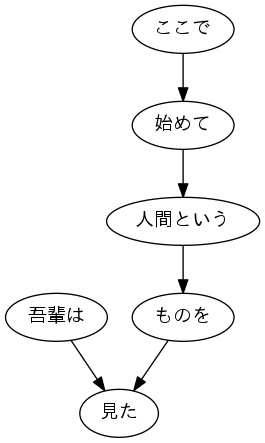

In [6]:
from itertools import groupby
import subprocess
import pydot
from IPython.display import Image, display
                        
def knock_44():
    INPUT_FILE_PATH = '../work/knock_44_input.txt'
    OUTPUT_FILE_PATH = '../work/knock_44_output.txt'

    def gen_chunks_in_file():
        with open(OUTPUT_FILE_PATH) as f:
            chunks_in_a_sentence = []
            for is_eos, sentence in groupby(f, key=lambda line: line.rstrip('\n') == 'EOS'):
                if is_eos:
                    for chunk in chunks_in_a_sentence:
                        # 各chunkの係り先のchunkに対して、自身のidをsrcとして設定
                        dst = chunk.dst
                        if dst:
                            chunks_in_a_sentence[dst].add_src(chunk.chunk_id)
                    yield chunks_in_a_sentence
                    chunks_in_a_sentence = []
                else:
                    dependency_info = None
                    # 表層形が '*' の場合と区別するため、'* 'で始まっている行をchunkの始まりとする
                    for is_start_of_chunk, chunk_info in groupby(sentence, key=lambda line: line.startswith('* ')):
                        if is_start_of_chunk:
                            dependency_info = list(chunk_info)[0]
                        else:
                            morphs_info = list(chunk_info)
                            chunk = Chunk(dependency_info, morphs_info)
                            chunks_in_a_sentence.append(chunk)
    
    def write_dependency_to_file(text):
        CMD_CAT = 'cat %s' % INPUT_FILE_PATH
        CMD_CABOCHA = 'cabocha -f1 -o %s' % OUTPUT_FILE_PATH
        
        with open(INPUT_FILE_PATH, "w") as f:
            f.write(text)
        ps = subprocess.Popen(CMD_CAT.split(' '), stdout=subprocess.PIPE)
        subprocess.check_call(CMD_CABOCHA.split(' '), stdin=ps.stdout)
        ps.wait()
        
    def to_pydot_node(chunk):
        surface = chunk.get_surface_except_punctuation()
        if surface == '':
            # 記号の除去後に空文字の場合はノードとして追加しない
            return None
        return pydot.Node(chunk.chunk_id, label=surface)
    
    def to_pydot_edge(src_chunk, dst_chunk):
        src_surface = src_chunk.get_surface_except_punctuation()
        dst_surface = dst_chunk.get_surface_except_punctuation()
        if src_surface == '' or dst_surface == '':
            # 記号の除去後に空文字の場合はノードとして追加しない
            return None
        # 矢印の向きは係り元から係り先の方向とする
        return graph.add_edge(pydot.Edge(src_chunk.chunk_id, dst_chunk.chunk_id))
    
    text = input()
    write_dependency_to_file(text)
    graph = pydot.Dot(graph_type='digraph')
    for chunks in gen_chunks_in_file():
        for chunk in chunks:
            print(chunk)
            
            node = to_pydot_node(chunk)
            if not node:
                continue
            graph.add_node(node)
                
            dst = chunk.dst
            if not dst:
                continue
            edge = to_pydot_edge(chunk, chunks[dst])
            if not edge:
                continue
            graph.add_edge(edge)
            
    plt = Image(graph.create_png())
    display(plt)

knock_44()

## 45. 動詞の格パターンの抽出
今回用いている文章をコーパスと見なし，日本語の述語が取りうる格を調査したい． 動詞を述語，動詞に係っている文節の助詞を格と考え，述語と格をタブ区切り形式で出力せよ． ただし，出力は以下の仕様を満たすようにせよ．

- 動詞を含む文節において，最左の動詞の基本形を述語とする
- 述語に係る助詞を格とする
- 述語に係る助詞（文節）が複数あるときは，すべての助詞をスペース区切りで辞書順に並べる

「吾輩はここで始めて人間というものを見た」という例文（neko.txt.cabochaの8文目）を考える． この文は「始める」と「見る」の２つの動詞を含み，「始める」に係る文節は「ここで」，「見る」に係る文節は「吾輩は」と「ものを」と解析された場合は，次のような出力になるはずである．

    始める  で
    見る    は を
このプログラムの出力をファイルに保存し，以下の事項をUNIXコマンドを用いて確認せよ．

- コーパス中で頻出する述語と格パターンの組み合わせ
- 「する」「見る」「与える」という動詞の格パターン（コーパス中で出現頻度の高い順に並べよ）

In [7]:
def knock_45():
    for chunks_in_a_sentence in gen_chunks_in_sentence():
        for chunk in chunks_in_a_sentence:
            if chunk.has_verb():
                srcs_particles = []
                for src in chunk.srcs:
                    src_particle = chunks_in_a_sentence[src].get_last_particle()
                    if src_particle:
                        srcs_particles.append(src_particle)
                if len(srcs_particles) == 0:
                    continue
                yield '%s\t%s' % (chunk.get_first_verb(), ' '.join(sorted(srcs_particles)))

with open('../work/knock_45.txt', mode='w') as f:
    for i, s in enumerate(knock_45()):
        if i < 150:
            print(s)
        f.write(s + '\n')

生れる	で
つく	か が
泣く	で
する	て は
始める	で
見る	は を
聞く	で
捕える	を
煮る	て
食う	て
思う	から
載せる	に
持ち上げる	て と
ある	が
落ちつく	で
見る	て を
見る	の
思う	と
残る	が でも
する	をもって
する	が
逢う	も
出会う	も
する	が
吹く	から を
弱る	て
飲む	の
知る	は
坐る	で に
おる	て
する	が で と
動く	が
動く	か が
分る	か
廻る	が が
なる	が
思う	と
する	が と
出る	から が て と
する	は
分る	が は も やら
付く	が
見る	て
いる	と は
見える	が も
隠す	さえ を
違う	は
明く	を
見る	て
棄てる	から に は へ
這い出す	で を
ある	が と に
坐る	に
する	て
考える	と
見る	て は
出る	も
泣く	て
来る	が に
考え付く	と
やる	に
見る	て
来る	が も
渡る	が と を
かかる	が て
減る	が に
出る	が も
ある	の
ある	まで
する	と を
そる	て
廻る	に も を
する	を
這う	て に
出る	で と へ
這入る	へ
思う	と
崩れる	の
もぐり込む	から て に
破れる	が
する	て に は
云う	は
至る	に
する	が まで を
なる	に は
忍び込む	は
分る	か ものの
なる	に
減る	は
降る	が
出来る	が で
あるく	と へ
考える	から
這入る	に
おる	て と は
見る	を
する	で に は
逢う	に
見る	で より を
つかむ	を
抛り出す	で は へ や
思う	と
ねぶる	を
任せる	から て に を
出来る	が は
見る	を
這う	て は へ
這う	は は
投げ出す	は
繰り返す	でも を
する	を
云う	と に
なる	は
する	を んで
下りる	から が
つまみ出す	が に
いう	と
出る	が ながら に
ぶら下げる	を
向ける	へ
出す	が
出す	て て も
上る	へ
困る	て は も
いう	と
撚る	を
眺める	ながら を
おる	て は
置く	へ
這入る	が といった へ
聞く	を
見える	と は
抛り出す	に は へ を
極める	と を
する	に は
合せる	と に を
帰る	から
這入る	に
出る	と
思う	と
いう	が
覗く	に を
見る	て は
する	を
ある	が が は


In [8]:
# コーパス中で頻出する述語と格パターンの組み合わせ
!cat ../work/knock_45.txt | sort | uniq -c | sort -nr 2>/dev/null | head -20

    704 云う	と
    452 する	を
    333 思う	と
    202 ある	が
    199 なる	に
    188 する	に
    175 見る	て
    159 する	と
    117 する	が
    113 する	に を
     98 見る	を
     97 見える	と
     90 する	て を
     85 する	は
     61 する	て
     60 もつ	を
     60 する	も
     60 する	が を
     57 ある	の
     56 云う	を


In [9]:
#「する」の格パターン（コーパス中で出現頻度の高い順に並べよ）
!cat ../work/knock_45.txt | grep '^する' | sort | uniq -c | sort -nr 2>/dev/null | head -20 

    452 する	を
    188 する	に
    159 する	と
    117 する	が
    113 する	に を
     90 する	て を
     85 する	は
     61 する	て
     60 する	も
     60 する	が を
     51 する	と を
     51 する	から
     46 する	で を
     40 する	の
     39 する	と は
     37 する	は を
     37 する	から を
     36 する	で
     32 する	が に
     32 する	が と


In [10]:
#「見る」の格パターン（コーパス中で出現頻度の高い順に並べよ）
!cat ../work/knock_45.txt | grep '^見る' | sort | uniq -c | sort -nr 2>/dev/null | head -20 

    175 見る	て
     98 見る	を
     23 見る	て て
     20 見る	から
     17 見る	と
     15 見る	て を
     13 見る	て は
     12 見る	で
     12 見る	から て
      9 見る	に
      8 見る	て と
      8 見る	が
      7 見る	に を
      7 見る	が を
      6 見る	も
      6 見る	と を
      6 見る	て も
      6 見る	て は を
      5 見る	で を
      4 見る	は を


In [11]:
#「与える」の格パターン（コーパス中で出現頻度の高い順に並べよ）
!cat ../data/knock_45.txt | grep '^与える' | sort | uniq -c | sort -nr

cat: ../data/knock_45.txt: No such file or directory


## 46. 動詞の格フレーム情報の抽出
45のプログラムを改変し，述語と格パターンに続けて項（述語に係っている文節そのもの）をタブ区切り形式で出力せよ．45の仕様に加えて，以下の仕様を満たすようにせよ．

- 項は述語に係っている文節の単語列とする（末尾の助詞を取り除く必要はない）
- 述語に係る文節が複数あるときは，助詞と同一の基準・順序でスペース区切りで並べる

「吾輩はここで始めて人間というものを見た」という例文（neko.txt.cabochaの8文目）を考える． この文は「始める」と「見る」の２つの動詞を含み，「始める」に係る文節は「ここで」，「見る」に係る文節は「吾輩は」と「ものを」と解析された場合は，次のような出力になるはずである．

    始める  で      ここで
    見る    は を   吾輩は ものを

In [12]:
from itertools import islice

def knock_46():
    for chunks_in_a_sentence in gen_chunks_in_sentence():
        for chunk in chunks_in_a_sentence:
            if chunk.has_verb():
                srcs_particles = []
                srcs_arguments = []
                for src in chunk.srcs:
                    src_chunk = chunks_in_a_sentence[src]
                    src_particle = src_chunk.get_last_particle()
                    if src_particle:
                        srcs_particles.append(src_particle)
                        srcs_arguments.append(src_chunk.get_surface_except_punctuation())
                if len(srcs_particles) == 0:
                    continue
                    
                # 助詞の辞書順になるように、助詞と項をソート
                particles_and_arguments = zip(srcs_particles, srcs_arguments)
                ordered_particles, ordered_arguments = zip(*sorted(particles_and_arguments, key=lambda x: x[0]))
                yield '%s\t%s\t%s' % (chunk.get_first_verb(), ' '.join(ordered_particles), ' '.join(ordered_arguments))
    
for s in islice(knock_46(), 20):
    print(s)

生れる	で	どこで
つく	か が	生れたか 見当が
泣く	で	所で
する	て は	泣いて いた事だけは
始める	で	ここで
見る	は を	吾輩は ものを
聞く	で	あとで
捕える	を	我々を
煮る	て	捕えて
食う	て	煮て
思う	から	なかったから
載せる	に	掌に
持ち上げる	て と	載せられて スーと
ある	が	感じが
落ちつく	で	上で
見る	て を	落ちついて 顔を
見る	の	ものの
思う	と	ものだと
残る	が でも	感じが 今でも
する	をもって	第一毛をもって


## 47. 機能動詞構文のマイニング
動詞のヲ格にサ変接続名詞が入っている場合のみに着目したい．46のプログラムを以下の仕様を満たすように改変せよ．

- 「サ変接続名詞+を（助詞）」で構成される文節が動詞に係る場合のみを対象とする
- 述語は「サ変接続名詞+を+動詞の基本形」とし，文節中に複数の動詞があるときは，最左の動詞を用いる
- 述語に係る助詞（文節）が複数あるときは，すべての助詞をスペース区切りで辞書順に並べる
- 述語に係る文節が複数ある場合は，すべての項をスペース区切りで並べる（助詞の並び順と揃えよ）

例えば「別段くるにも及ばんさと、主人は手紙に返事をする。」という文から，以下の出力が得られるはずである．

    返事をする      と に は        及ばんさと 手紙に 主人は

このプログラムの出力をファイルに保存し，以下の事項をUNIXコマンドを用いて確認せよ．

- コーパス中で頻出する述語（サ変接続名詞+を+動詞）
- コーパス中で頻出する述語と助詞パターン

In [13]:
from itertools import islice

def knock_47():
    for chunks_in_a_sentence in gen_chunks_in_sentence():
        for chunk in chunks_in_a_sentence:
            if chunk.has_verb():
                sahen_noun_and_verb = None
                srcs_particles = []
                srcs_arguments = []
                for src in chunk.srcs:
                    src_chunk = chunks_in_a_sentence[src]
                    src_particle = src_chunk.get_last_particle()
                    if src_particle:
                        if src_particle == 'を':
                            sahen_noun_wo = src_chunk.get_sahen_noun_and_wo()
                            if sahen_noun_wo:
                                # サ変接続名詞 + を（助詞） + 動詞の基本形
                                sahen_noun_and_verb = sahen_noun_wo + chunk.get_first_verb()
                        else:
                            srcs_particles.append(src_particle)
                            srcs_arguments.append(src_chunk.get_surface_except_punctuation())
                if not sahen_noun_and_verb:
                    continue
                    
                ordered_particles = []
                ordered_arguments = []
                if len(srcs_particles) != 0:
                    # 助詞の辞書順になるように、助詞と項をソート
                    particles_and_arguments = zip(srcs_particles, srcs_arguments)
                    ordered_particles, ordered_arguments = zip(*sorted(particles_and_arguments, key=lambda x: x[0]))
                yield '%s\t%s\t%s' % (sahen_noun_and_verb, ' '.join(ordered_particles), ' '.join(ordered_arguments))
    
with open('../work/knock_47.txt', mode='w') as f:
    for i, s in enumerate(knock_47()):
        if i < 20:
            print(s)
        f.write(s + '\n')

決心をする	と	こうと
返報をする	んで	偸んで
昼寝をする		
昼寝をする	が	彼が
迫害を加える	て	追い廻して
生活をする	が	我等猫族が
話をする		
投書をする	て へ	やって ほととぎすへ
話をする	に	時に
写生をする		
昼寝をする	て	出て
彩色を見る		
欠伸をする	から て て	なったから して 押し出して
報道をする	に	耳に
挨拶をする		
御馳走を食う	と	見ると
問答をする		
雑談をする	ながら は	寝転びながら 黒は
自慢をする		
呼吸を飲み込む	から	なってから


In [14]:
# コーパス中で頻出する述語（サ変接続名詞+を+動詞）
!cut -f 1 ../work/knock_47.txt | sort | uniq -c | sort -nr 2>/dev/null | head -20

     30 返事をする
     21 挨拶をする
     16 話をする
     14 真似をする
     13 喧嘩をする
      8 質問をする
      7 運動をする
      6 話を聞く
      6 注意をする
      6 昼寝をする
      5 問答をする
      5 病気をする
      5 相談をする
      5 質問をかける
      4 放蕩をする
      4 戦争をする
      4 辞儀をする
      4 散歩をする
      4 降参をする
      4 欠伸をする


In [15]:
# コーパス中で頻出する述語と助詞パターン
!cut -f 1,2 ../work/knock_47.txt | grep -E ".+\s+.+" | sort | uniq -c | sort -nr 2>/dev/null | head -20

      6 返事をする	と
      4 返事をする	と は
      4 挨拶をする	と
      4 挨拶をする	から
      3 質問をかける	と は
      3 喧嘩をする	と
      2 返事をする	から と
      2 同情を表する	て と は
      2 講義をする	で
      2 休養を要する	は
      2 議論をする	て
      2 覚悟をする	と
      2 安心を得る	が
      2 挨拶をする	と も
      2 挨拶をする	で
      1 薨去を落ちる	て
      1 吶喊を喰う	と
      1 話を聞く	は
      1 話を聞く	として に まで
      1 話を致す	が


## 48. 名詞から根へのパスの抽出
文中のすべての名詞を含む文節に対し，その文節から構文木の根に至るパスを抽出せよ． ただし，構文木上のパスは以下の仕様を満たすものとする．

各文節は（表層形の）形態素列で表現する
パスの開始文節から終了文節に至るまで，各文節の表現を"->"で連結する
「吾輩はここで始めて人間というものを見た」という文（neko.txt.cabochaの8文目）から，次のような出力が得られるはずである．

    吾輩は -> 見た
    ここで -> 始めて -> 人間という -> ものを -> 見た
    人間という -> ものを -> 見た
    ものを -> 見た

In [16]:
from itertools import islice
from functools import lru_cache

def knock_48():
    DEPENDENCY_ARROW = ' -> '
    
    @lru_cache(maxsize = 20)
    def get_path_to_root(src_chunk, chunks_in_a_sentence):
        if src_chunk.dst:
            dst_chunk = chunks_in_a_sentence[src_chunk.dst]
            src_surface = src_chunk.get_surface_except_punctuation()
            dst_surface = get_path_to_root(dst_chunk, chunks_in_a_sentence)
            return src_surface + DEPENDENCY_ARROW + dst_surface
        else:
            return src_chunk.get_surface_except_punctuation()        
    
    for chunks_in_a_sentence in gen_chunks_in_sentence():
        for chunk in chunks_in_a_sentence:
            if chunk.has_noun():
                path_to_root = get_path_to_root(chunk, tuple(chunks_in_a_sentence))
                if DEPENDENCY_ARROW in path_to_root:
                    yield path_to_root
    
for path_to_root in islice(knock_48(), 20):
    print(path_to_root)

吾輩は -> 猫である
名前は -> 無い
どこで -> 生れたか -> つかぬ
見当が -> つかぬ
何でも -> 薄暗い -> 所で -> 泣いて -> 記憶している
所で -> 泣いて -> 記憶している
ニャーニャー -> 泣いて -> 記憶している
いた事だけは -> 記憶している
吾輩は -> 見た
ここで -> 始めて -> 人間という -> ものを -> 見た
人間という -> ものを -> 見た
ものを -> 見た
あとで -> 聞くと -> 種族であったそうだ
それは -> 種族であったそうだ
書生という -> 人間中で -> 種族であったそうだ
人間中で -> 種族であったそうだ
一番 -> 獰悪な -> 種族であったそうだ
獰悪な -> 種族であったそうだ
書生というのは -> 話である
我々を -> 捕えて -> 煮て -> 食うという -> 話である


## 49. 名詞間の係り受けパスの抽出
文中のすべての名詞句のペアを結ぶ最短係り受けパスを抽出せよ．ただし，名詞句ペアの文節番号がiとj（i<j）のとき，係り受けパスは以下の仕様を満たすものとする．

 - 問題48と同様に，パスは開始文節から終了文節に至るまでの各文節の表現（表層形の形態素列）を"->"で連結して表現する
 - 文節iとjに含まれる名詞句はそれぞれ，XとYに置換する

また，係り受けパスの形状は，以下の2通りが考えられる．

 - 文節iから構文木の根に至る経路上に文節jが存在する場合: 文節iから文節jのパスを表示
 - 上記以外で，文節iと文節jから構文木の根に至る経路上で共通の文節kで交わる場合: 文節iから文節kに至る直前のパスと文節jから文節kに至る直前までのパス，文節kの内容を"|"で連結して表示
 
例えば，「吾輩はここで始めて人間というものを見た。」という文（neko.txt.cabochaの8文目）から，次のような出力が得られるはずである．

    Xは | Yで -> 始めて -> 人間という -> ものを | 見た
    Xは | Yという -> ものを | 見た
    Xは | Yを | 見た
    Xで -> 始めて -> Y
    Xで -> 始めて -> 人間という -> Y
    Xという -> Y

In [21]:
from itertools import islice, combinations

def knock_49():
    DEPENDENCY_ARROW = ' -> '
    
    def exists_branch_between(i_chunk, j_chunk, chunks_in_a_sentence):
        i_current = i_chunk
        while i_current.dst:
            i_dst_chunk = chunks_in_a_sentence[i_current.dst]
            if i_dst_chunk is j_chunk:
                return False
            i_current = i_dst_chunk
        return True

    def get_branch_path(i_chunk, j_chunk, chunks_in_a_sentence):
        i_current = i_chunk
        j_current = j_chunk
        i_phrase = i_chunk.get_masked_noun_phrase('X')
        while i_current.dst:
            i_dst_chunk = chunks_in_a_sentence[i_current.dst]
            j_phrase = j_chunk.get_masked_noun_phrase('Y')
            while j_current.dst:
                j_dst_chunk = chunks_in_a_sentence[j_current.dst]
                if i_dst_chunk is j_dst_chunk:
                    return i_phrase + ' | ' + j_phrase + ' | ' + j_dst_chunk.get_surface_except_punctuation()
                j_current = j_dst_chunk
                j_phrase += DEPENDENCY_ARROW + j_current.get_surface_except_punctuation()
            i_current = i_dst_chunk
            i_phrase += DEPENDENCY_ARROW + i_current.get_surface_except_punctuation()
            
        # 共通の文節がない場合はNoneを返す
        return None
    
    def get_path_from_to(from_chunk, to_chunk, chunks_in_a_sentence):
        i_current = from_chunk
        phrase = from_chunk.get_masked_noun_phrase('X')
        
        while i_current.dst:
            i_dst_chunk = chunks_in_a_sentence[i_current.dst]
            if i_dst_chunk is to_chunk:
                phrase += DEPENDENCY_ARROW + i_dst_chunk.get_masked_noun_phrase('Y', should_remove_kaku_particle=True)
                return phrase
            else:
                phrase += DEPENDENCY_ARROW + i_dst_chunk.get_surface_except_punctuation()
            i_current = i_dst_chunk
            
        raise AssertionError('A path from "from_chunk" to "to_chunk" is not found. \n' + 
                             'from_chunk:' + str(from_chunk) +
                             '\nto_chunk: ' + str(to_chunk) + 
                             '\nsentence:\n' + '\n'.join(str(chunk) for chunk in chunks_in_a_sentence))
            
    for chunks_in_a_sentence in gen_chunks_in_sentence():
        noun_phrases = []
        for chunk in chunks_in_a_sentence:
            if chunk.has_noun():
                # 名詞を含む節を名詞句とする
                noun_phrases.append(chunk)
        
        for i_chunk, j_chunk in combinations(noun_phrases, 2):
            if exists_branch_between(i_chunk, j_chunk, chunks_in_a_sentence):
                branch_path = get_branch_path(i_chunk, j_chunk, chunks_in_a_sentence)
                if branch_path:
                    yield branch_path
            else:
                yield get_path_from_to(i_chunk, j_chunk, chunks_in_a_sentence)
    
for path_to_root in islice(knock_49(), 2000000):
    print(path_to_root)

Xは -> Y
Xでも -> 薄暗い -> Y
Xでも -> 薄暗い -> 所で -> 泣いて -> Y
Xで | Y | 泣いて
Xで -> 泣いて -> Y
X -> 泣いて -> Y
Xだけは -> Y
Xは | Yで -> 始めて -> 人間という -> ものを | 見た
Xは | Yという -> ものを | 見た
Xは | Yを | 見た
Xで -> 始めて -> Y
Xで -> 始めて -> 人間という -> Y
Xという -> Y
Xで -> 聞くと -> Y
Xは | Yという -> 人間中で | 種族であったそうだ
Xは | Yで | 種族であったそうだ
Xは | Y -> 獰悪な | 種族であったそうだ
Xは | Y | 種族であったそうだ
Xは -> Y
Xという -> Y
Xという -> 人間中で -> Y
Xで | Y -> 獰悪な | 種族であったそうだ
Xで | Y | 種族であったそうだ
Xで -> Y
X -> Y
X -> 獰悪な -> Y
X -> Y
Xというは | Yを -> 捕えて -> 煮て -> 食うという | 話である
Xというは -> Y
Xを -> 捕えて -> 煮て -> 食うという -> Y
Xは | Yという -> 考も | なかったから
Xは | Yも | なかったから
Xという -> Y
Xの -> Y
Xの -> 掌に -> 載せられて -> 持ち上げられた -> Y
Xの -> 掌に -> 載せられて -> 持ち上げられた -> 時 -> フワフワした -> Y
Xに -> 載せられて -> 持ち上げられた -> Y
Xに -> 載せられて -> 持ち上げられた -> 時 -> フワフワした -> Y
Xと -> 持ち上げられた -> Y
Xと -> 持ち上げられた -> 時 -> フワフワした -> Y
X -> フワフワした -> Y
Xの -> Y
Xの -> 上で -> 落ちついて -> Y
Xの -> 上で -> 落ちついて -> 見たのが -> Y
Xの -> 上で -> 落ちついて -> 見たのが -> 人間という -> Y
Xの -> 上で -> 落ちついて -> 見たのが -> 人間という -> ものの -> Y
Xで -> 落ちついて -> Y
Xで -> 落ちついて -> 見た

Xに | Y -> ものが | 睡られる
Xに | Yが | 睡られる
Xに | Yまで | 睡られる
Xに | Yに | 睡られる
Xに -> 睡られる -> Y
X -> Y
X -> ものが -> 睡られる -> Y
Xが | Yまで | 睡られる
Xが | Yに | 睡られる
Xが -> 睡られる -> Y
Xまで | Yに | 睡られる
Xまで -> 睡られる -> Y
Xに -> 睡られる -> Y
Xかと | Yは | 驚かざるを得なかった
Xかと | Yに | 驚かざるを得なかった
Xかと | Y -> 度胸に | 驚かざるを得なかった
Xかと | Yに | 驚かざるを得なかった
Xは | Yに | 驚かざるを得なかった
Xは | Y -> 度胸に | 驚かざるを得なかった
Xは | Yに | 驚かざるを得なかった
Xに | Y -> 度胸に | 驚かざるを得なかった
Xに | Yに | 驚かざるを得なかった
X -> Y
Xは | Yの | 黒猫である
Xは -> Y
Xの -> Y
Xを -> 過ぎたる -> Y
Xは | Y -> 光線を -> かけて -> する -> 柔毛の -> 間より -> 見えぬ -> 炎でも | 思われた
Xは | Yを -> かけて -> する -> 柔毛の -> 間より -> 見えぬ -> 炎でも | 思われた
Xは | Yの -> 皮膚の -> 上に -> かけて -> する -> 柔毛の -> 間より -> 見えぬ -> 炎でも | 思われた
Xは | Yの -> 上に -> かけて -> する -> 柔毛の -> 間より -> 見えぬ -> 炎でも | 思われた
Xは | Yに -> かけて -> する -> 柔毛の -> 間より -> 見えぬ -> 炎でも | 思われた
Xは | Y -> かけて -> する -> 柔毛の -> 間より -> 見えぬ -> 炎でも | 思われた
Xは | Yの -> 間より -> 見えぬ -> 炎でも | 思われた
Xは | Yより -> 見えぬ -> 炎でも | 思われた
Xは | Yに -> 見えぬ -> 炎でも | 思われた
Xは | Yでも | 思われた
Xは | Yに | 思われた
X -> Y
X -> 光線を -> かけて -> する -> Y
X -> 光

Xは | Yを -> かいても -> 駄目だという -> 目付で | あるそうだ
Xは | Yという -> 目付で | あるそうだ
Xは | Yで | あるそうだ
Xは | Yは -> 冗談だが | あるそうだ
Xは | Yが | あるそうだ
Xは | Yという -> ものは -> ものだよ | あるそうだ
Xは | Yは -> ものだよ | あるそうだ
Xは | Yよ | あるそうだ
Xは | Yは | あるそうだ
Xは | Yに -> 写せと -> 教えた -> 事が | あるそうだ
Xは | Yの -> 壁の -> しみを -> 写せと -> 教えた -> 事が | あるそうだ
Xは | Yの -> しみを -> 写せと -> 教えた -> 事が | あるそうだ
Xは | Yを -> 写せと -> 教えた -> 事が | あるそうだ
Xは | Yが | あるそうだ
Xは -> Y
Xから | Yを -> かいても | 駄目だという
Xから -> Y
Xから -> 駄目だという -> Y
Xから -> 駄目だという -> 目付で -> Y
Xを -> かいても -> Y
Xを -> かいても -> 駄目だという -> Y
Xを -> かいても -> 駄目だという -> 目付で -> Y
Xという -> Y
Xという -> 目付で -> Y
Xで | Yは -> 冗談だが | あるそうだ
Xで | Yが | あるそうだ
Xで | Yという -> ものは -> ものだよ | あるそうだ
Xで | Yは -> ものだよ | あるそうだ
Xで | Yよ | あるそうだ
Xで | Yは | あるそうだ
Xで | Yに -> 写せと -> 教えた -> 事が | あるそうだ
Xで | Yの -> 壁の -> しみを -> 写せと -> 教えた -> 事が | あるそうだ
Xで | Yの -> しみを -> 写せと -> 教えた -> 事が | あるそうだ
Xで | Yを -> 写せと -> 教えた -> 事が | あるそうだ
Xで | Yが | あるそうだ
Xで -> Y
Xは -> Y
Xは -> 冗談だが -> Y
Xが | Yという -> ものは -> ものだよ | あるそうだ
Xが | Yは -> ものだよ | あるそうだ
Xが | Yよ | あるそうだ
Xが | 

Xを -> Y
Xを -> 分配してくれる -> Y
Xて -> Y
Xが | Yの -> 中から | すくい出して
Xが | Yから | すくい出して
Xが | Yの -> 砂糖を | すくい出して
Xが | Yを | すくい出して
Xの -> Y
Xから | Yの -> 砂糖を | すくい出して
Xから | Yを | すくい出して
Xの -> Y
Xの -> Y
Xの -> 皿の -> Y
Xの -> Y
Xが | Yの | した
Xが -> した -> Y
Xの -> した -> Y
X | Yの -> 砂糖を | あけた
X | Yを | あけた
X | Yで | あけた
X | Yの -> 皿の -> 上に | あけた
X | Yの -> 上に | あけた
X | Yに | あけた
Xの -> Y
Xを | Yで | あけた
Xを | Yの -> 皿の -> 上に | あけた
Xを | Yの -> 上に | あけた
Xを | Yに | あけた
Xで | Yの -> 皿の -> 上に | あけた
Xで | Yの -> 上に | あけた
Xで | Yに | あけた
Xの -> Y
Xの -> 皿の -> Y
Xの -> Y
Xが | Yを -> とって | 加えた
Xが | Yを | 加えた
Xが | Yの -> 上に | 加えた
Xが | Yに | 加えた
Xを | Yの -> 上に | 加えた
Xを | Yに | 加えた
Xの -> Y
Xも | Yを -> とって | した
Xも | Yを | した
Xも | Yと -> 同一に | した
Xも | Yに | した
Xを | Yと -> 同一に | した
Xを | Yに | した
Xと -> Y
Xが | Y | すくった
Xも -> 負けずに -> Y
Xを -> Y
Xが | Yへ -> 懸ける | とる
Xが | Yを -> 懸ける | とる
Xが | Yが | とる
Xが | Yを | とる
Xへ | Yを | 懸ける
Xが | Yを | とる
Xに | Y -> 一杯 -> 一杯と | 重なって
Xに | Y -> 一杯と | 重なって
Xに | Yと | 重なって
X -> Y
X -> 一杯 -> Y
X -> Y
Xの -> Y
Xには | Yの -> 砂糖が | 堆くなって
Xには | 

Xの -> 小供の -> Y
Xの -> 小供の -> 足音が -> Y
Xの -> Y
Xの -> 足音が -> Y
Xが | Yへ | 近付くのを
Xが -> Y
Xへ -> Y
Xは | Yも -> なく -> 見棄てたろうしかも | 浮ばなかったろう
Xは | Yを -> 見棄てたろうしかも | 浮ばなかったろう
Xは | Yの -> 事は | 浮ばなかったろう
Xは | Yは | 浮ばなかったろう
Xは | Yまで | 浮ばなかったろう
Xは | Yに | 浮ばなかったろう
Xの -> Y
Xは | Yまで | 浮ばなかったろう
Xは | Yに | 浮ばなかったろう
Xまで | Yに | 浮ばなかったろう
Xてても | Yも | 来ない
X -> Y
Xは | Yの -> 中を -> 覗き込みながら -> 来てくれればいいと | 念じた
Xは | Yを -> 覗き込みながら -> 来てくれればいいと | 念じた
Xは | Yか -> 来てくれればいいと | 念じた
Xの -> Y
Xは | Yを | 食わなければならぬ
Xにから | Yの | 重量を
Xにから -> Y
Xにから -> 重量を -> Y
Xの -> Y
Xの -> 重量を -> Y
Xを | Yの -> 底へ | 落すようにして
Xを | Yへ | 落すようにして
Xを -> Y
Xの -> Y
Xの -> 底へ -> Y
Xへ -> Y
Xにて | Yと -> 餅の -> 角を | 食い込んだ
Xにて | Yの -> 角を | 食い込んだ
Xにて | Yを | 食い込んだ
Xにて | Yばかり | 食い込んだ
Xと -> Y
Xと -> 餅の -> Y
Xの -> Y
Xを | Yばかり | 食い込んだ
Xを -> 込めて -> Y
Xを -> 込めて -> 食い付いたのだから -> Y
Xから | Y -> ものなら | 噛み切れる訳だが
Xから | Y | 噛み切れる訳だが
Xから -> Y
X -> Y
X -> ものなら -> Y
X -> Y
Xが | Yを -> 引こうとすると | 引けない
Xは | Yなと -> 疳づいた -> 時は | 遅かった
Xは | Y -> 時は | 遅かった
Xは | Yは | 遅かった
Xなと -> Y
Xなと -> 疳づいた -> Y
X 

Xは -> 分らなかったんですが -> Y
Xは -> 分らなかったんですが -> あるのだろうと -> 思いまして -> Y
Xは -> 分らなかったんですが -> あるのだろうと -> 思いまして -> 驚いたのです -> Y
Xにも -> Y
Xにも -> 分らなかったんですが -> Y
Xにも -> 分らなかったんですが -> あるのだろうと -> 思いまして -> Y
Xにも -> 分らなかったんですが -> あるのだろうと -> 思いまして -> 驚いたのです -> Y
Xが | Yの -> 事ですから | あるのだろうと
Xが | Yから | あるのだろうと
Xが | Yか | あるのだろうと
Xが | Yが | あるのだろうと
Xが -> Y
Xが -> あるのだろうと -> 思いまして -> Y
Xが -> あるのだろうと -> 思いまして -> 驚いたのです -> Y
Xの -> Y
Xの -> 事ですから -> Y
Xの -> 事ですから -> あるのだろうと -> 思いまして -> Y
Xの -> 事ですから -> あるのだろうと -> 思いまして -> 驚いたのです -> Y
Xから | Yか | あるのだろうと
Xから | Yが | あるのだろうと
Xから -> Y
Xから -> あるのだろうと -> 思いまして -> Y
Xから -> あるのだろうと -> 思いまして -> 驚いたのです -> Y
Xか | Yが | あるのだろうと
Xか -> Y
Xか -> あるのだろうと -> 思いまして -> Y
Xか -> あるのだろうと -> 思いまして -> 驚いたのです -> Y
Xが -> Y
Xが -> あるのだろうと -> 思いまして -> Y
Xが -> あるのだろうと -> 思いまして -> 驚いたのです -> Y
Xと -> 思いまして -> Y
Xと -> 思いまして -> 驚いたのです -> Y
Xに -> 行きましたか -> なるほど -> Y
Xに -> 行きましたか -> なるほど -> 驚いたのです -> Y
X -> Y
Xは | Y -> 見たかと | 云わぬばかりに
Xの -> Y
Xの -> 上に -> 乗った -> Y
Xの -> 上に -> 乗った -> 吾輩の -> Y
Xに -> 乗った -> Y


Xは | Yを | 前める
Xは -> Y
Xの -> Y
Xの -> 通信を -> 読む -> くらいの -> Y
Xの -> 通信を -> 読む -> くらいの -> 意気込で -> Y
Xを -> 読む -> くらいの -> Y
Xを -> 読む -> くらいの -> 意気込で -> Y
Xで | Yを | 前める
Xで -> Y
Xを -> Y
Xが -> 出て来て -> 云うと -> 繰り返さるるので -> 参りませんから -> Y
Xが -> 出て来て -> 云うと -> 繰り返さるるので -> 参りませんから -> 合せたのです -> Y
Xが -> 出て来て -> 云うと -> 繰り返さるるので -> 参りませんから -> 合せたのです -> ごもっともでと -> Y
Xは | Yの -> 材料が -> 行っても -> 行っても | 買われませんから
Xは | Yが -> 行っても -> 行っても | 買われませんから
Xは | Yで -> 行っても -> 行っても | 買われませんから
Xは | Yへ -> 行っても -> 行っても | 買われませんから
Xは | Yの -> 十五番へ -> 行っても | 買われませんから
Xは | Yへ -> 行っても | 買われませんから
Xは -> 買われませんから -> 云うと -> 繰り返さるるので -> 参りませんから -> Y
Xは -> 買われませんから -> 云うと -> 繰り返さるるので -> 参りませんから -> 合せたのです -> Y
Xは -> 買われませんから -> 云うと -> 繰り返さるるので -> 参りませんから -> 合せたのです -> ごもっともでと -> Y
Xの -> Y
Xの -> 材料が -> 行っても -> 行っても -> 買われませんから -> 云うと -> 繰り返さるるので -> 参りませんから -> Y
Xの -> 材料が -> 行っても -> 行っても -> 買われませんから -> 云うと -> 繰り返さるるので -> 参りませんから -> 合せたのです -> Y
Xの -> 材料が -> 行っても -> 行っても -> 買われませんから -> 云うと -> 繰り返さるるので -> 参りませんから -> 合せたのです -> ごもっともでと -> Y
Xが | 

Xの -> 仮色を -> 使って -> やっていると -> ものですから -> 驚ろいたし -> Y
Xの -> 仮色を -> 使って -> やっていると -> ものですから -> 驚ろいたし -> 悪るいし -> 折られてから -> つづけられないので -> Y
Xの -> 仮色を -> 使って -> やっていると -> ものですから -> 驚ろいたし -> 悪るいし -> 折られてから -> つづけられないので -> 散会しました -> Y
Xの -> 仮色を -> 使って -> やっていると -> ものですから -> 驚ろいたし -> 悪るいし -> 折られてから -> つづけられないので -> 散会しました -> 第一回としては -> Y
Xの -> 仮色を -> 使って -> やっていると -> ものですから -> 驚ろいたし -> 悪るいし -> 折られてから -> つづけられないので -> 散会しました -> 第一回としては -> ものだろうと -> Y
Xを -> 使って -> やっていると -> Y
Xを -> 使って -> やっていると -> ものですから -> Y
Xを -> 使って -> やっていると -> ものですから -> 驚ろいたし -> Y
Xを -> 使って -> やっていると -> ものですから -> 驚ろいたし -> 悪るいし -> 折られてから -> つづけられないので -> Y
Xを -> 使って -> やっていると -> ものですから -> 驚ろいたし -> 悪るいし -> 折られてから -> つづけられないので -> 散会しました -> Y
Xを -> 使って -> やっていると -> ものですから -> 驚ろいたし -> 悪るいし -> 折られてから -> つづけられないので -> 散会しました -> 第一回としては -> Y
Xを -> 使って -> やっていると -> ものですから -> 驚ろいたし -> 悪るいし -> 折られてから -> つづけられないので -> 散会しました -> 第一回としては -> ものだろうと -> Y
X -> Y
X -> 大丈夫と -> 思って -> やっていると -> Y
X -> 大丈夫と -> 思って -> やっていると -> ものですから -> Y
X -> 大丈夫と ->

Xが -> 凋んで -> Y
Xの -> Y
Xの -> 梅が -> Y
Xが | Yながら | 開きかかるのを
Xが -> Y
Xながら -> Y
X -> Y
X -> 三毛子を -> Y
Xを -> Y
Xは | Yと | 思ったが
Xには | Yで | 寝ているという
Xには -> 寝ているという -> Y
Xで -> 寝ているという -> Y
Xの -> Y
Xの -> 中で -> Y
Xで | Yの -> 御師匠さんと | しているのを
Xで | Yと | しているのを
Xで | Yが | しているのを
Xで -> Y
Xの -> Y
Xの -> 御師匠さんと -> Y
Xと | Yが | しているのを
Xと -> Y
Xが -> Y
Xを | Yの -> 葉蘭の -> 影に | 隠れて
Xを | Yの -> 影に | 隠れて
Xを | Yに | 隠れて
Xの -> Y
Xの -> 葉蘭の -> Y
Xの -> Y
Xは | Yを | たべるかい
Xは -> たべるかい -> 寝かしておきました -> Y
Xを -> たべるかい -> 寝かしておきました -> Y
Xから | Yにも | 食べません
Xから -> 食べません -> あったかに -> して -> 寝かしておきました -> Y
Xにも -> 食べません -> あったかに -> して -> 寝かしておきました -> Y
Xに -> 寝かしておきました -> Y
Xの -> Y
Xの -> Y
Xが -> 愛している -> Y
Xが | Yまで | 受けていると
Xが | Yを | 受けていると
Xまで | Yを | 受けていると
Xを -> たべないと -> 疲れるばかりだからね -> Y
Xが -> 疲れるばかりだからね -> Y
Xでさえ | Yを | いただかないと
Xでさえ -> いただかないと -> Y
Xを -> いただかないと -> Y
Xは -> Y
Xは | Yより -> 動物であるような -> 返事を | する
Xは | Yの -> 方が -> 動物であるような -> 返事を | する
Xは | Yが -> 動物であるような -> 返事を | する
Xは | Y -> 動物であるような -> 返事を | する
Xは | Y -> 返事を | する
Xは | Yを | する


Xを -> 願うと -> 云う -> 先き -> Y
X -> Y
Xから | Yに | 待っていると
Xを -> 食って -> 読んでいる -> Y
Xの -> Y
Xの -> 前で -> 読んでいる -> Y
Xで | Yの -> 滑稽物を | 読んでいる
Xで | Yを | 読んでいる
Xで -> 読んでいる -> Y
Xの -> Y
Xの -> 滑稽物を -> 読んでいる -> Y
Xを -> 読んでいる -> Y
Xへ | Yの -> 母から | 来たから
Xへ | Yから | 来たから
Xへ | Yが | 来たから
Xの -> Y
Xから | Yが | 来たから
Xを | Yのに | 思ってね
Xは | Yを -> するなとか | いいが
Xは | Yも | いいが
Xは -> いいが -> Y
Xを -> するなとか -> いいが -> Y
Xも -> いいが -> Y
Xを -> 焚いて -> してやらないと -> 引くとか -> Y
Xを | Yかに | してやらないと
Xを -> してやらないと -> 引くとか -> Y
Xかに -> してやらないと -> 引くとか -> Y
Xを -> 引くとか -> Y
Xの -> Y
Xの -> 注意が -> Y
Xが -> Y
Xは -> Y
Xは -> ものだ -> いかないと -> Y
X | Yでは | いかないと
X -> いかないと -> Y
Xでは -> いかないと -> Y
X -> Y
X -> 僕も -> Y
Xも | Yだけは | 感動した
Xも | Yに | 感動した
Xも -> Y
Xだけは | Yに | 感動した
Xだけは -> Y
Xに -> Y
Xか -> Y
Xでもて | Yを | 揚げなくては
Xの -> 生きている -> Y
Xの -> 生きている -> うちに -> して -> 知らしめたいと -> 云う -> Y
Xに | Yを | して
Xに -> して -> 知らしめたいと -> 云う -> Y
Xを -> して -> 知らしめたいと -> 云う -> Y
Xの -> Y
Xの -> 文壇に -> 知らしめたいと -> 云う -> Y
Xに | Yを | 知らしめたいと
Xに -> 知らしめたいと -> 云う -> Y
Xを -> 知らしめたいと -> 云う -

Xへ -> Y
Xに | Yが | いい
Xまでに -> 行かなくては -> Y
Xを -> とらなくちゃ -> 這入れないからですと -> 教えられた -> Y
Xの -> Y
Xの -> 君代さんから -> 教えられた -> Y
Xから -> 教えられた -> Y
Xじゃ | Yを | 過ぎれば
Xじゃ -> 過ぎれば -> Y
Xを -> 過ぎれば -> Y
Xねと | Yを -> 押して | 見たら
X -> Y
X -> 不思議な -> Y
X -> Y
Xには | Yから | し出してね
Xには | Yに | し出してね
Xには | Yが | し出してね
Xから | Yに | し出してね
Xから | Yが | し出してね
Xに | Yが | し出してね
Xがかと | Yが | 聞く
Xの -> 明いた -> Y
Xの -> 明いた -> 風船玉のように -> Y
Xの -> 明いた -> 風船玉のように -> 萎縮する -> Y
Xのに | Yに | 萎縮する
Xのに -> Y
Xのに -> 萎縮する -> Y
Xに -> Y
Xに -> 萎縮する -> Y
X -> Y
Xねと | Yが | 加える
Xねと | Yを | 加える
Xが | Yを | 加える
Xが | Yに -> 一度の | 願だから
Xが | Yの | 願だから
Xが -> Y
Xに -> Y
Xに -> 一度の -> Y
Xの -> Y
X -> 叱りつけたり -> 聞かなかったり -> させたり -> 酬いた -> Y
Xを -> 聞かなかったり -> させたり -> 酬いた -> Y
Xの -> Y
Xの -> 苦労を -> させたり -> 酬いた -> Y
Xを -> させたり -> 酬いた -> Y
Xの -> Y
Xの -> 世話を -> させたりするばかりで -> 酬いた -> Y
Xを -> させたりするばかりで -> 酬いた -> Y
Xの -> Y
Xの -> 労に -> 酬いた -> Y
Xに -> 酬いた -> Y
Xは | Yも | ある
Xには | Yの -> 堵物も | ある
Xには | Yも | ある
Xの -> Y
Xが -> して -> くらんでは -> 乗るどころか -> 降りる -> Y
Xが -> くらんでは -> 乗るどころか -> 降りる 

Xは | Yの -> 名産吉備団子を -> 届けてくれた -> 人が | ある
Xは | Yを -> 届けてくれた -> 人が | ある
Xは | Yの -> 名宛で -> 届けてくれた -> 人が | ある
Xは | Yで -> 届けてくれた -> 人が | ある
Xは | Yが | ある
Xの -> Y
Xの -> 名産吉備団子を -> 届けてくれた -> Y
Xを | Yの -> 名宛で | 届けてくれた
Xを | Yで | 届けてくれた
Xを -> 届けてくれた -> Y
Xの -> Y
Xの -> 名宛で -> 届けてくれた -> Y
Xで -> 届けてくれた -> Y
Xから | Yを | 寄せら
Xから -> Y
Xから -> 寄せら -> るるに従って -> Y
Xを -> Y
Xを -> 寄せら -> るるに従って -> Y
X -> るるに従って -> Y
Xが -> Y
Xが -> 猫である -> Y
Xが -> 猫である -> 事は -> Y
X -> Y
X -> 事は -> Y
Xは -> Y
Xよりは | Yの -> 方へ -> 接近して来たような -> 心持に -> なって | 毛頭ない
Xよりは | Yへ -> 接近して来たような -> 心持に -> なって | 毛頭ない
Xよりは | Yて -> 心持に -> なって | 毛頭ない
Xよりは | Yに -> なって | 毛頭ない
Xよりは | Yを -> 糾合して -> 云う -> 量見は | 毛頭ない
Xよりは | Yて -> 云う -> 量見は | 毛頭ない
Xよりは | Yの -> 先生と -> 雌雄を -> 云う -> 量見は | 毛頭ない
Xよりは | Yと -> 雌雄を -> 云う -> 量見は | 毛頭ない
Xよりは | Yを -> 云う -> 量見は | 毛頭ない
Xよりは | Yなどと -> 云う -> 量見は | 毛頭ない
Xよりは | Yは | 毛頭ない
Xよりは | Yの -> ところ | 毛頭ない
Xよりは | Y | 毛頭ない
Xの -> Y
Xの -> 方へ -> Y
Xの -> 方へ -> 接近して来たような -> Y
Xへ -> Y
Xへ -> 接近して来たような -> Y
Xて -> Y
Xを -> Y
Xを -> 糾合して -> 云う -> Y

Xを | Yに | くべて
Xを -> くべて -> Y
Xを -> くべて -> 焚いてしまったそうです -> しましたな -> Y
Xを -> くべて -> 焚いてしまったそうです -> しましたな -> 書いてあるんですって -> Y
Xに -> くべて -> Y
Xに -> くべて -> 焚いてしまったそうです -> しましたな -> Y
Xに -> くべて -> 焚いてしまったそうです -> しましたな -> 書いてあるんですって -> Y
X | Yを | しましたな
X -> しましたな -> Y
X -> しましたな -> 書いてあるんですって -> Y
Xを -> しましたな -> Y
Xを -> しましたな -> 書いてあるんですって -> Y
Xの -> Y
Xの -> 内には -> Y
Xの -> 内には -> 書いてあるんですって -> Y
Xには | Yか -> 何か -> 見られない -> 事が | 書いてあるんですって
Xには | Yか -> 見られない -> 事が | 書いてあるんですって
Xには | Yで -> 見られない -> 事が | 書いてあるんですって
Xには | Yが | 書いてあるんですって
Xには -> Y
Xには -> 書いてあるんですって -> Y
Xか -> Y
Xか -> 何か -> 見られない -> Y
Xか -> 何か -> 見られない -> 事が -> Y
Xか -> 何か -> 見られない -> 事が -> 書いてあるんですって -> Y
Xか | Yで | 見られない
Xか -> 見られない -> Y
Xか -> 見られない -> 事が -> Y
Xか -> 見られない -> 事が -> 書いてあるんですって -> Y
Xで -> 見られない -> Y
Xで -> 見られない -> 事が -> Y
Xで -> 見られない -> 事が -> 書いてあるんですって -> Y
Xが -> Y
Xが -> 書いてあるんですって -> Y
Xって | Yは -> なったから -> 減ったろうと -> 思って -> 聞くと | くべたそうです
Xって | Yが -> なったから -> 減ったろうと -> 思って -> 聞くと | くべたそうです
Xって | Yに -> なったから -> 減ったろうと -> 思っ

Xを -> 引張って -> 釣し上げた -> ものと -> 見るのです -> 好いんだろう -> Y
X -> Y
X -> ものと -> Y
X -> ものと -> 見るのです -> Y
X -> ものと -> 見るのです -> 好いんだろう -> Y
Xと -> Y
Xと -> 見るのです -> Y
Xと -> 見るのです -> 好いんだろう -> Y
X | Yの -> シャツのように -> ぶら下ったと -> 見れば | 好いんだろう
X | Yのに -> ぶら下ったと -> 見れば | 好いんだろう
X | Yが -> ぶら下ったと -> 見れば | 好いんだろう
X -> Y
X -> 好いんだろう -> Y
Xの -> Y
Xの -> シャツのように -> ぶら下ったと -> 見れば -> Y
Xの -> シャツのように -> ぶら下ったと -> 見れば -> 好いんだろう -> Y
Xのに | Yが | ぶら下ったと
Xのに -> ぶら下ったと -> 見れば -> Y
Xのに -> ぶら下ったと -> 見れば -> 好いんだろう -> Y
Xが -> ぶら下ったと -> 見れば -> Y
Xが -> ぶら下ったと -> 見れば -> 好いんだろう -> Y
X | Yで | 釣るのです
X | Yは | 釣るのです
X | Yの -> 一端を -> 括り付けて | 釣るのです
X | Yを -> 括り付けて | 釣るのです
X | Yの -> ごとく -> 括り付けて | 釣るのです
X | Yへ -> 括り付けて | 釣るのです
X | Yの -> 一端も | 釣るのです
X | Yも | 釣るのです
X | Yから | 釣るのです
X | Yへ | 釣るのです
X -> Y
Xで | Yは | 釣るのです
Xで | Yの -> 一端を -> 括り付けて | 釣るのです
Xで | Yを -> 括り付けて | 釣るのです
Xで | Yの -> ごとく -> 括り付けて | 釣るのです
Xで | Yへ -> 括り付けて | 釣るのです
Xで | Yの -> 一端も | 釣るのです
Xで | Yも | 釣るのです
Xで | Yから | 釣るのです
Xで | Yへ | 釣るのです
Xで -> Y
Xは | Yの -> 一端を -> 括り付けて | 釣るので

Xの -> Y
Xよりも | Yの -> 先生の -> 方が -> えらいと | 信じている
Xよりも | Yの -> 方が -> えらいと | 信じている
Xよりも | Yが -> えらいと | 信じている
Xの -> Y
Xの -> 先生の -> Y
Xの -> Y
Xも | Yの -> 利かぬ -> 性質として -> 蒙る -> 事は -> 覚束ないと | めている
Xも | Yとして -> 蒙る -> 事は -> 覚束ないと | めている
Xも | Y -> 金満家の -> 恩顧を -> 蒙る -> 事は -> 覚束ないと | めている
Xも | Yの -> 恩顧を -> 蒙る -> 事は -> 覚束ないと | めている
Xも | Yを -> 蒙る -> 事は -> 覚束ないと | めている
Xも | Yは -> 覚束ないと | めている
Xも | Yと | めている
Xも | Y | めている
Xも -> Y
Xの -> 利かぬ -> Y
Xの -> 利かぬ -> 性質として -> 蒙る -> Y
Xの -> 利かぬ -> 性質として -> 蒙る -> 事は -> Y
Xの -> 利かぬ -> 性質として -> 蒙る -> 事は -> 覚束ないと -> Y
Xとして | Y -> 金満家の -> 恩顧を | 蒙る
Xとして | Yの -> 恩顧を | 蒙る
Xとして | Yを | 蒙る
Xとして -> 蒙る -> Y
Xとして -> 蒙る -> 事は -> Y
Xとして -> 蒙る -> 事は -> 覚束ないと -> Y
X -> Y
X -> 金満家の -> Y
X -> 金満家の -> 恩顧を -> 蒙る -> Y
X -> 金満家の -> 恩顧を -> 蒙る -> 事は -> Y
X -> 金満家の -> 恩顧を -> 蒙る -> 事は -> 覚束ないと -> Y
Xの -> Y
Xの -> 恩顧を -> 蒙る -> Y
Xの -> 恩顧を -> 蒙る -> 事は -> Y
Xの -> 恩顧を -> 蒙る -> 事は -> 覚束ないと -> Y
Xを -> 蒙る -> Y
Xを -> 蒙る -> 事は -> Y
Xを -> 蒙る -> 事は -> 覚束ないと -> Y
Xは -> Y
Xは -> 覚束ないと -> Y
Xと | Y | めている
Xと

Xだって | Yを | 使わないんでしょう
Xだって -> Y
Xだって -> 使わないんでしょう -> Y
Xを -> Y
Xを -> 使わないんでしょう -> Y
X | Y -> 逢ったら | 注意しておきましょうと
X -> Y
X -> 逢ったら -> Y
Xてと | Yが | 笑う
Xで | Yが | かけるくらいじゃ
Xで -> かけるくらいじゃ -> 悪いと -> 思われますが -> Y
Xで -> かけるくらいじゃ -> 悪いと -> 思われますが -> ものでしょう -> Y
Xが -> かけるくらいじゃ -> 悪いと -> 思われますが -> Y
Xが -> かけるくらいじゃ -> 悪いと -> 思われますが -> ものでしょう -> Y
Xの -> Y
Xの -> 性が -> 悪いと -> 思われますが -> Y
Xの -> 性が -> 悪いと -> 思われますが -> ものでしょう -> Y
Xが -> 悪いと -> 思われますが -> Y
Xが -> 悪いと -> 思われますが -> ものでしょう -> Y
X -> Y
X -> ものでしょう -> Y
X -> Y
Xね | Yは -> ないが | あるよ
Xね | Yが | あるよ
X -> 填めない -> Y
X -> 填めない -> ところが -> Y
Xが -> Y
Xだに | Yに | なってるなあ
Xだに -> なってるなあ -> Y
Xだに -> なってるなあ -> 奇観だぜ -> Y
Xだに -> なってるなあ -> 奇観だぜ -> 訳でもないでしょうから御安心なさいよと -> Y
Xに -> なってるなあ -> Y
Xに -> なってるなあ -> 奇観だぜ -> Y
Xに -> なってるなあ -> 奇観だぜ -> 訳でもないでしょうから御安心なさいよと -> Y
Xぜ | Yを -> 填める -> 小遣が -> ないので -> しておくんですかまたは -> 物好きで -> しておくんでしょうか | 訳でもないでしょうから御安心なさいよと
Xぜ | Yが -> ないので -> しておくんですかまたは -> 物好きで -> しておくんでしょうか | 訳でもないでしょうから御安心なさいよと
Xぜ | Yなりに -> しておくんですかまたは -> 物好きで -> しておくんで

Xやら -> 神さんやら -> 天璋院まで -> 買収して -> 知らぬ -> 間に -> 欠けたのさえ -> 探偵しているのに -> Y
Xの -> Y
Xの -> 神さんやら -> Y
Xの -> 神さんやら -> 天璋院まで -> Y
Xの -> 神さんやら -> 天璋院まで -> 買収して -> 知らぬ -> Y
Xの -> 神さんやら -> 天璋院まで -> 買収して -> 知らぬ -> 間に -> Y
Xの -> 神さんやら -> 天璋院まで -> 買収して -> 知らぬ -> 間に -> 欠けたのさえ -> Y
Xの -> 神さんやら -> 天璋院まで -> 買収して -> 知らぬ -> 間に -> 欠けたのさえ -> 探偵しているのに -> Y
Xやら | Yの | 天璋院まで
Xやら -> Y
Xやら -> 天璋院まで -> Y
Xやら -> 天璋院まで -> 買収して -> 知らぬ -> Y
Xやら -> 天璋院まで -> 買収して -> 知らぬ -> 間に -> Y
Xやら -> 天璋院まで -> 買収して -> 知らぬ -> 間に -> 欠けたのさえ -> Y
Xやら -> 天璋院まで -> 買収して -> 知らぬ -> 間に -> 欠けたのさえ -> 探偵しているのに -> Y
Xの -> Y
Xの -> 天璋院まで -> Y
Xの -> 天璋院まで -> 買収して -> 知らぬ -> Y
Xの -> 天璋院まで -> 買収して -> 知らぬ -> 間に -> Y
Xの -> 天璋院まで -> 買収して -> 知らぬ -> 間に -> 欠けたのさえ -> Y
Xの -> 天璋院まで -> 買収して -> 知らぬ -> 間に -> 欠けたのさえ -> 探偵しているのに -> Y
Xまで -> Y
Xまで -> 買収して -> 知らぬ -> Y
Xまで -> 買収して -> 知らぬ -> 間に -> Y
Xまで -> 買収して -> 知らぬ -> 間に -> 欠けたのさえ -> Y
Xまで -> 買収して -> 知らぬ -> 間に -> 欠けたのさえ -> 探偵しているのに -> Y
Xて -> 知らぬ -> Y
Xて -> 知らぬ -> 間に -> Y
Xて -> 知らぬ -> 間に -> 欠けたのさえ -> Y
Xて -> 知らぬ -> 間

Xで | Yが | する
Xの -> Y
Xにも | Yか | ある
Xにも | Yが | ある
Xか | Yが | ある
Xにと | Yへ | 向ける
Xにと | Yを | 向ける
Xへ | Yを | 向ける
Xが | Yで | 話している
Xが | Yか | 話している
Xが | Yで | 話している
Xで | Yか | 話している
Xで | Yで | 話している
Xか | Yで | 話している
Xが | Yと | 似ている
Xが -> 似ている -> Y
Xが -> 似ている -> ところを -> もって -> 推すと -> Y
Xと -> 似ている -> Y
Xと -> 似ている -> ところを -> もって -> 推すと -> Y
Xを -> もって -> 推すと -> Y
Xが | Yの -> 令嬢 -> 寒月君を | して
Xが | Y -> 寒月君を | して
Xが | Yを | して
Xが -> して -> せしめたる -> Y
Xの -> Y
Xの -> 令嬢 -> Y
Xの -> 令嬢 -> 寒月君を -> して -> せしめたる -> Y
X -> Y
X -> 寒月君を -> して -> せしめたる -> Y
Xを -> して -> せしめたる -> Y
Xを -> せしめたる -> Y
Xで | Yの -> 御姿を | 拝する
Xで | Yを | 拝する
Xで -> 拝する -> Y
Xの -> Y
Xの -> 御姿を -> 拝する -> Y
Xを -> 拝する -> Y
Xの -> Y
Xに | Yを | 祭り込んでいるか
Xの -> Y
Xの -> 模様から -> Y
Xから | Yの -> 荒い -> ところなどを | 綜合して
Xから | Yなどを | 綜合して
Xから -> Y
Xの -> 荒い -> Y
Xの -> 荒い -> ところなどを -> Y
Xなどを -> Y
Xの -> Y
Xの -> 注意を -> 惹かぬ -> Y
Xを -> 惹かぬ -> Y
Xは | Yって | いるが
Xは -> いるが -> Y
Xって -> いるが -> Y
Xの -> Y
Xの -> 声が -> Y
Xの -> 声が -> 聞えないのは -> Y
Xが -> Y
Xが -> 聞えないのは -> Y
Xは | Yに -> きく -> 電

Xで -> ちょん切って -> Y
Xで -> ちょん切って -> 安置したら -> Y
Xて | Yの -> 猫の -> 顔へ | 安置したら
Xて | Yの -> 顔へ | 安置したら
Xて | Yへ | 安置したら
Xて -> Y
Xて -> 安置したら -> Y
Xの -> Y
Xの -> 猫の -> Y
Xの -> 猫の -> 顔へ -> Y
Xの -> 猫の -> 顔へ -> 安置したら -> Y
Xの -> Y
Xの -> 顔へ -> Y
Xの -> 顔へ -> 安置したら -> Y
Xへ -> Y
Xへ -> 安置したら -> Y
X -> Y
Xにも | Yの -> 額と -> 云うくらいな -> 地面へ | 聳えたら
Xにも | Yと -> 云うくらいな -> 地面へ | 聳えたら
Xにも | Yへ | 聳えたら
Xにも | Yの -> 鼻柱が | 聳えたら
Xにも | Yが | 聳えたら
Xにも | Yとして | 聳えたら
Xにも -> 聳えたら -> Y
Xの -> Y
Xの -> 額と -> 云うくらいな -> Y
Xの -> 額と -> 云うくらいな -> 地面へ -> 聳えたら -> Y
Xと -> 云うくらいな -> Y
Xと -> 云うくらいな -> 地面へ -> 聳えたら -> Y
Xへ | Yの -> 鼻柱が | 聳えたら
Xへ | Yが | 聳えたら
Xへ | Yとして | 聳えたら
Xへ -> 聳えたら -> Y
Xの -> Y
Xの -> 鼻柱が -> 聳えたら -> Y
Xが | Yとして | 聳えたら
Xが -> 聳えたら -> Y
Xとして -> 聳えたら -> Y
Xの -> Y
Xの -> 上へ -> Y
Xの -> 上へ -> 据え付けたような -> Y
Xの -> 上へ -> 据え付けたような -> もので -> Y
Xへ | Yの -> 大仏を | 据え付けたような
Xへ | Yを | 据え付けたような
Xへ -> Y
Xへ -> 据え付けたような -> Y
Xへ -> 据え付けたような -> もので -> Y
Xの -> Y
Xの -> 大仏を -> Y
Xの -> 大仏を -> 据え付けたような -> Y
Xの -> 大仏を -> 据え付けたような -> もので -> Y
Xを -> Y
Xを -> 据

Xかか | Yから -> 見透かさるる -> 恐れが | あると
Xかか | Yが | あると
Xから -> 見透かさるる -> Y
Xを | Yへ | 廻って
Xの -> Y
Xの -> 横から -> 知らぬ -> Y
Xから -> 知らぬ -> Y
Xに | Yの -> 下へ | 出る
Xに | Yへ | 出る
Xの -> Y
Xを -> した -> Y
Xを -> した -> 覚は -> ないから -> Y
Xは -> ないから -> Y
Xも -> 隠れる -> Y
Xも -> 隠れる -> 事も -> Y
Xも | Yも | ないのだが
Xも -> Y
Xも -> Y
Xが | Yが -> 云う -> 無法者に -> 逢っては -> 不運と -> 諦めるより -> ないので | 出ずるであろう
Xが | Yと -> 云う -> 無法者に -> 逢っては -> 不運と -> 諦めるより -> ないので | 出ずるであろう
Xが | Yに -> 逢っては -> 不運と -> 諦めるより -> ないので | 出ずるであろう
Xが | Yと -> 諦めるより -> ないので | 出ずるであろう
Xが | Yが -> ないので | 出ずるであろう
Xが | Yが -> なったら | 出ずるであろう
Xが | Yばかりに -> なったら | 出ずるであろう
Xが | Yの -> 君子も | 出ずるであろう
Xが | Yも | 出ずるであろう
Xが | Yの -> 態度に | 出ずるであろう
Xが | Yに | 出ずるであろう
Xが | Yと | 云う
Xが -> 云う -> Y
Xが -> 云う -> 無法者に -> 逢っては -> Y
Xと -> 云う -> Y
Xと -> 云う -> 無法者に -> 逢っては -> Y
Xに -> 逢っては -> Y
Xが | Yばかりに | なったら
Xの -> Y
Xも | Yの -> 態度に | 出ずるであろう
Xも | Yに | 出ずるであろう
Xの -> Y
Xは | Yから -> あるまいが | あるそうである
Xは | Yのに -> 振り廻す -> 気遣は -> あるまいが | あるそうである
Xは | Y -> 三寸を -> 振り廻す -> 気遣は -> あるまいが | あるそうである
Xは | Yを -> 振り廻

Xの -> 時代は -> Y
Xは | Yは | 遭遇しつつある
Xは | Y -> 変色の -> 時期に | 遭遇しつつある
Xは | Yの -> 時期に | 遭遇しつつある
Xは | Yに | 遭遇しつつある
Xは -> Y
Xは | Y -> 変色の -> 時期に | 遭遇しつつある
Xは | Yの -> 時期に | 遭遇しつつある
Xは | Yに | 遭遇しつつある
Xは -> Y
X -> Y
X -> 変色の -> Y
X -> 変色の -> 時期に -> Y
Xの -> Y
Xの -> 時期に -> Y
Xに -> Y
Xを -> Y
Xを -> 経過して -> 化けるまで -> 続くかどうだかは -> Y
Xて | Yの -> 暗黒色に | 化けるまで
Xて | Yに | 化けるまで
Xて -> 化けるまで -> 続くかどうだかは -> Y
Xの -> Y
Xの -> 暗黒色に -> 化けるまで -> 続くかどうだかは -> Y
Xに -> 化けるまで -> 続くかどうだかは -> Y
Xの -> Y
Xの -> 命が -> 続くかどうだかは -> Y
Xが -> 続くかどうだかは -> Y
Xでも | Y -> なく | 擦り切れて
Xでも -> 擦り切れて -> Y
X -> なく -> 擦り切れて -> Y
Xの -> Y
Xの -> 筋は -> Y
Xは | Yかに -> 読まれる -> くらいだから | 適当である
Xは | Yと -> 称するのは -> 沙汰であって -> 申すのが | 適当である
Xは | Yは -> 沙汰であって -> 申すのが | 適当である
Xは | Yの -> 沙汰であって -> 申すのが | 適当である
Xは | Yて -> 申すのが | 適当である
Xは | Yの -> 字は -> 申すのが | 適当である
Xは | Yは -> 申すのが | 適当である
Xは | Yとでも -> 申すのが | 適当である
Xは | Yが | 適当である
Xは -> Y
Xかに -> 読まれる -> くらいだから -> Y
Xと -> Y
Xと -> 称するのは -> Y
Xと -> 称するのは -> 沙汰であって -> Y
Xと -> 称するのは -> 沙汰であって -> 申すのが -> Y
Xは | Yの | 沙汰であって

Xの -> Y
Xまで -> ぶら下げなくちゃ -> Y
Xにてねと | Yは | 見せる
Xにてねと | Yを -> して | 見せる
Xにてねと | Yに -> して | 見せる
Xは | Yを -> して | 見せる
Xは | Yに -> して | 見せる
Xを | Yに | して
Xもの -> Y
Xと | Yは | かける
Xと | Y -> 質問を | かける
Xと | Yを | かける
Xは | Y -> 質問を | かける
Xは | Yを | かける
X -> Y
Xよと | Yは | 答えたが
Xも | Yを | 取ったね
Xが -> Y
Xが -> あるはずだったが -> Y
Xが -> Y
Xか -> Y
X -> Y
X -> Y
X -> Y
X -> 大きいのは -> なるかね -> Y
Xは | Yに | なるかね
Xは -> なるかね -> Y
Xに -> なるかね -> Y
Xか -> Y
Xか -> 能く知らんが -> Y
Xが | Yか | 七つかだろう
Xが -> Y
Xか -> Y
Xは | Y | いいな
Xも | Yにでも -> なれば | 善かった
Xで -> Y
X -> Y
X -> 気楽で -> あって -> 出来て -> Y
X | Yが | あって
X -> あって -> 出来て -> Y
Xが -> あって -> 出来て -> Y
X -> Y
X -> 勉強が -> 出来て -> Y
Xが -> 出来て -> Y
Xも -> 悪くもないが -> Y
Xの -> Y
Xの -> うちは -> Y
Xは -> Y
Xの -> Y
Xの -> 方に -> なると -> つまらん -> Y
Xの -> 方に -> なると -> つまらん -> 御世辞を -> 振り撒いたり -> 出たり -> Y
Xに -> なると -> つまらん -> Y
Xに -> なると -> つまらん -> 御世辞を -> 振り撒いたり -> 出たり -> Y
Xを -> 振り撒いたり -> 出たり -> Y
Xを | Yに | 出たり
Xを -> 出たり -> Y
Xに -> 出たり -> Y
X -> Y
Xは | Yは | 大嫌だ
Xは | Yから | 大嫌だ
Xは -> Y
Xは | Yから | 大嫌だ
Xは -> Y
Xから -

Xと | Yは | 振り廻す
Xと | Y -> 美学を | 振り廻す
Xと | Yを | 振り廻す
Xは | Y -> 美学を | 振り廻す
Xは | Yを | 振り廻す
X -> Y
Xの -> Y
X | Yは | 専攻するつもりだから
X | Yを | 専攻するつもりだから
X -> Y
X -> 専攻するつもりだから -> Y
X -> 専攻するつもりだから -> 可哀相だのと -> 云う -> Y
X -> 専攻するつもりだから -> 可哀相だのと -> 云う -> 私情は -> Y
X -> 専攻するつもりだから -> 可哀相だのと -> 云う -> 私情は -> ところでないと -> Y
Xは | Yを | 専攻するつもりだから
Xは -> Y
Xは -> 専攻するつもりだから -> Y
Xは -> 専攻するつもりだから -> 可哀相だのと -> 云う -> Y
Xは -> 専攻するつもりだから -> 可哀相だのと -> 云う -> 私情は -> Y
Xは -> 専攻するつもりだから -> 可哀相だのと -> 云う -> 私情は -> ところでないと -> Y
Xを -> Y
Xを -> 専攻するつもりだから -> Y
Xを -> 専攻するつもりだから -> 可哀相だのと -> 云う -> Y
Xを -> 専攻するつもりだから -> 可哀相だのと -> 云う -> 私情は -> Y
Xを -> 専攻するつもりだから -> 可哀相だのと -> 云う -> 私情は -> ところでないと -> Y
Xから | Yの -> 面白い -> 出来事は | 可哀相だのと
Xから | Yは | 可哀相だのと
Xから | Yてて -> 供さなければならん | 可哀相だのと
Xから | Yの -> 参考に -> 供さなければならん | 可哀相だのと
Xから | Yに -> 供さなければならん | 可哀相だのと
Xから | Yば | 可哀相だのと
Xから | Yだの | 可哀相だのと
Xから -> Y
Xから -> 可哀相だのと -> 云う -> Y
Xから -> 可哀相だのと -> 云う -> 私情は -> Y
Xから -> 可哀相だのと -> 云う -> 私情は -> ところでないと -> Y
Xの -> 面白い -> Y
Xの -> 面白い -> 出来事は -> Y

Xが -> 成就した -> ところへ -> 有するかと -> 飛び込んで来たので -> 喰っている -> Y
Xまで -> Y
Xまで -> 成就した -> Y
Xまで -> 成就した -> ところへ -> 有するかと -> 飛び込んで来たので -> 喰っている -> Y
X -> Y
X -> ところへ -> 有するかと -> 飛び込んで来たので -> 喰っている -> Y
Xへ | Y -> 常規を -> もって -> 律すべからざる | 有するかと
Xへ | Yを -> もって -> 律すべからざる | 有するかと
Xへ | Yの -> 人間以外の -> 心理作用を | 有するかと
Xへ | Yの -> 心理作用を | 有するかと
Xへ | Yを | 有するかと
Xへ -> 有するかと -> 飛び込んで来たので -> 喰っている -> Y
X -> Y
X -> 常規を -> もって -> 律すべからざる -> 有するかと -> 飛び込んで来たので -> 喰っている -> Y
Xを -> もって -> 律すべからざる -> 有するかと -> 飛び込んで来たので -> 喰っている -> Y
Xの -> Y
Xの -> 人間以外の -> Y
Xの -> 人間以外の -> 心理作用を -> 有するかと -> 飛び込んで来たので -> 喰っている -> Y
Xの -> Y
Xの -> 心理作用を -> 有するかと -> 飛び込んで来たので -> 喰っている -> Y
Xを -> 有するかと -> 飛び込んで来たので -> 喰っている -> Y
X | Yが | 飛び込んで来たので
X -> 飛び込んで来たので -> 喰っている -> Y
Xが -> 飛び込んで来たので -> 喰っている -> Y
X -> 喰っている -> Y
Xを -> Y
Xを -> 発明した -> Y
Xを -> 発明した -> ものは -> Y
X -> Y
X -> ものは -> Y
Xは | Yの -> 紳士で -> 鈴木藤十郎君で | 鈴木藤十郎君である
Xは | Yで -> 鈴木藤十郎君で | 鈴木藤十郎君である
Xは | Yを -> 実行する -> ものは -> 鈴木藤十郎君で | 鈴木藤十郎君である
Xは | Y -> ものは -> 鈴木藤十郎君で | 鈴木藤十郎君である
Xは |

Xは | Yにとっても | 急所である
Xは -> Y
Xにとっても -> Y
Xは | Yが | ないから
Xにゃと -> Y
Xか | Yばかりは | 出ない
Xか | Yに -> 思うような -> 声が | 出ない
Xか | Yが -> 思うような -> 声が | 出ない
Xか | Y -> 思うような -> 声が | 出ない
Xか | Y -> 声が | 出ない
Xか | Yが | 出ない
Xばかりは | Yに -> 思うような -> 声が | 出ない
Xばかりは | Yが -> 思うような -> 声が | 出ない
Xばかりは | Y -> 思うような -> 声が | 出ない
Xばかりは | Y -> 声が | 出ない
Xばかりは | Yが | 出ない
Xに | Yが | 思うような
Xに | Y | 思うような
Xに -> Y
Xに -> 思うような -> Y
Xが | Y | 思うような
Xが -> Y
Xが -> 思うような -> Y
X -> Y
X -> 思うような -> Y
X -> Y
Xで -> 渋りながら -> 低い -> Y
Xの -> Y
Xは | Yも | ないのに
Xの -> Y
Xと -> Y
Xと | Y | めて
Xと -> Y
Xと -> めて -> Y
X -> Y
X -> めて -> Y
Xて | Yと -> 柳行李の -> 間に -> 忍ばせて | 窺がう
Xて | Yの -> 間に -> 忍ばせて | 窺がう
Xて | Yに -> 忍ばせて | 窺がう
Xて | Yを -> 忍ばせて | 窺がう
Xて | Yを | 窺がう
Xて -> Y
Xと -> Y
Xと -> 柳行李の -> Y
Xと -> 柳行李の -> 間に -> 忍ばせて -> Y
Xの -> Y
Xの -> 間に -> 忍ばせて -> Y
Xに | Yを | 忍ばせて
Xに -> 忍ばせて -> Y
Xを -> 忍ばせて -> Y
Xを -> Y
Xの -> Y
Xの -> 足音は -> Y
Xは | Yの -> 障子の -> 前へ -> 来て | 已む
Xは | Yの -> 前へ -> 来て | 已む
Xは | Yへ -> 来て | 已む
Xは -> Y
Xの -> Y
Xの -> 障子の -> Y
Xの -> 障子の -> 前へ -> 来て ->

Xは | Y -> 在っても | 平気かも知れん
Xは | Yが -> 在っても | 平気かも知れん
Xは | Yに -> 在っても | 平気かも知れん
Xは -> Y
Xに -> 使う -> Y
Xに -> 使う -> 三盆を -> 入れるくらい -> 云う -> Y
Xに -> 使う -> 三盆を -> 入れるくらい -> 云う -> 観念に -> 乏しい -> Y
Xに -> 使う -> 三盆を -> 入れるくらい -> 云う -> 観念に -> 乏しい -> 女であるから -> とれば -> Y
Xを | Yへ | 入れるくらい
Xを -> 入れるくらい -> 云う -> Y
Xを -> 入れるくらい -> 云う -> 観念に -> 乏しい -> Y
Xを -> 入れるくらい -> 云う -> 観念に -> 乏しい -> 女であるから -> とれば -> Y
Xへ -> 入れるくらい -> 云う -> Y
Xへ -> 入れるくらい -> 云う -> 観念に -> 乏しい -> Y
Xへ -> 入れるくらい -> 云う -> 観念に -> 乏しい -> 女であるから -> とれば -> Y
Xの -> Y
Xの -> 適不適と -> 云う -> Y
Xの -> 適不適と -> 云う -> 観念に -> 乏しい -> Y
Xの -> 適不適と -> 云う -> 観念に -> 乏しい -> 女であるから -> とれば -> Y
Xと -> 云う -> Y
Xと -> 云う -> 観念に -> 乏しい -> Y
Xと -> 云う -> 観念に -> 乏しい -> 女であるから -> とれば -> Y
Xに -> 乏しい -> Y
Xに -> 乏しい -> 女であるから -> とれば -> Y
Xから | Yに | とれば
Xから -> とれば -> Y
Xに -> とれば -> Y
Xは | Y -> 在っても | 平気かも知れん
Xは | Yが -> 在っても | 平気かも知れん
Xは | Yに -> 在っても | 平気かも知れん
Xは -> Y
X | Yが | 在っても
X | Yに | 在っても
X -> 在っても -> Y
Xが | Yに | 在っても
Xが -> 在っても -> Y
Xに -> 在っても -> Y
X -> Y
Xは | Yと -> 知ろ

Xは | Yは | ありますのに
Xは -> ありますのに -> Y
Xに -> Y
Xに -> 三四百円の -> Y
Xに -> 三四百円の -> 収入は -> ありますのに -> Y
Xの -> Y
Xの -> 収入は -> ありますのに -> Y
Xは -> ありますのに -> Y
X | Yと -> 云う -> 工学士を | 知ってなさるか
X | Yを | 知ってなさるか
Xと -> 云う -> Y
X | Y -> ある | 宴会で
X -> Y
X -> 宴会で -> 逢いました -> Y
X -> 宴会で -> 逢いました -> 時 -> したら -> Y
X -> ある -> Y
X -> ある -> 宴会で -> 逢いました -> Y
X -> ある -> 宴会で -> 逢いました -> 時 -> したら -> Y
Xで -> 逢いました -> Y
Xで -> 逢いました -> 時 -> したら -> Y
X | Yの -> 御話を | したら
X | Yを | したら
X -> したら -> Y
Xの -> Y
Xの -> 御話を -> したら -> Y
Xを -> したら -> Y
Xは | Y -> 沙弥君の -> ところの -> 書生を | していたのか
Xは | Yの -> ところの -> 書生を | していたのか
Xは | Yの -> 書生を | していたのか
Xは | Yを | していたのか
Xは -> Y
X -> Y
X -> 沙弥君の -> Y
X -> 沙弥君の -> ところの -> Y
X -> 沙弥君の -> ところの -> 書生を -> Y
Xの -> Y
Xの -> ところの -> Y
Xの -> ところの -> 書生を -> Y
Xの -> Y
Xの -> 書生を -> Y
Xを -> Y
Xか | Yも -> し -> おった -> 事が -> ある -> 云うてくれ | 尋ねるからと
Xか | Yとは -> し -> おった -> 事が -> ある -> 云うてくれ | 尋ねるからと
Xか | Y -> し -> おった -> 事が -> ある -> 云うてくれ | 尋ねるからと
Xか | Yの -> 寺で -> して -> おった -> 事が -> ある -> 云うてくれ | 尋ねるからと
Xか | Yで -

Xに -> Y
Xを -> 付けて -> 見ると -> Y
Xで -> 見ると -> Y
Xから -> Y
Xを | Yに | やり過ごしておいて
Xから | Yを | かける
X -> Y
X -> 煤が -> Y
Xが | Yの -> 光で | 輝やいて
Xが | Yで | 輝やいて
Xが -> Y
Xの -> Y
Xの -> 光で -> Y
Xで -> Y
Xて | Yを -> 裏返しに -> 釣るしたごとく -> 上る -> 事も | 出来ん
Xて | Yの -> 手際では -> 上る -> 事も | 出来ん
Xて | Yでは -> 上る -> 事も | 出来ん
Xて | Yも | 出来ん
Xて | Yも | 出来ん
Xを -> 裏返しに -> 釣るしたごとく -> 上る -> Y
Xの -> Y
Xの -> 手際では -> 上る -> Y
Xでは -> 上る -> Y
Xも | Yも | 出来ん
Xから -> 落ちてくる -> Y
Xだけは | Yを -> 解く -> 事に | する
Xだけは | Yに | する
Xを -> 解く -> Y
Xから -> Y
Xから -> 攻撃される -> Y
X -> Y
X | Yでも -> 退治して | 見せる
X | Yて | 見せる
Xでも -> Y
X | Yが | ある
Xに | Yを | 捕るべく
Xも | Yの -> 付けようが | ない
Xも | Yが | ない
Xの -> Y
Xの -> Y
Xの -> 黒ごとき -> Y
Xの -> 黒ごとき -> ものを -> Y
Xの -> 黒ごとき -> ものを -> 頼んでくるのも -> Y
X -> Y
X -> ものを -> Y
X -> ものを -> 頼んでくるのも -> Y
Xを | Yに | 頼んでくるのも
Xを -> Y
Xを -> 頼んでくるのも -> Y
Xに -> Y
Xに -> 頼んでくるのも -> Y
Xも | Yの | 威厳に関する
Xも -> Y
Xの -> Y
Xが -> 出ない -> Y
Xが -> 出ない -> 時は -> Y
Xは | Yは -> ないと -> 決めるのが -> 得る | 近道である
Xは | Yは -> ないと -> 決めるのが -> 得る | 近道である
Xは | Yが -> 得る | 近道である
Xは 

Xが | Yに | 齷齪する
Xが -> Y
Xが -> 齷齪する -> Y
Xが -> 齷齪する -> 様子を -> Y
Xが -> 齷齪する -> 様子を -> 拝見しようかと -> 考えて -> 見たが -> Y
Xに -> Y
Xに -> 齷齪する -> Y
Xに -> 齷齪する -> 様子を -> Y
Xに -> 齷齪する -> 様子を -> 拝見しようかと -> 考えて -> 見たが -> Y
X -> Y
X -> 様子を -> Y
X -> 様子を -> 拝見しようかと -> 考えて -> 見たが -> Y
Xを -> Y
Xを -> 拝見しようかと -> 考えて -> 見たが -> Y
Xかと -> 考えて -> 見たが -> Y
Xは | Yに関して | 性分である
Xは | Yに -> 近い | 性分である
Xは -> Y
Xに関して | Yに -> 近い | 性分である
Xに関して -> Y
Xに -> 近い -> Y
Xは | Yに -> 劣らぬくらい | やるし
Xを -> しても -> Y
Xを -> しても -> 観察する -> Y
X -> Y
Xに | Yでも | 来ると
Xの -> Y
Xも | Yか | 呈して
Xも | Yを | 呈して
Xか | Yを | 呈して
X -> 来ても -> Y
Xとも -> 知らず -> 浴びる -> Y
Xで | Yを | 浴びる
Xで -> 浴びる -> Y
Xを -> 浴びる -> Y
Xを -> 浴びる -> Y
Xばかりは | Yで | 入れている
Xばかりは | Yの -> 手を | 入れている
Xばかりは | Yを | 入れている
Xで | Yの -> 手を | 入れている
Xで | Yを | 入れている
Xの -> Y
X -> Y
X -> 一杯などと -> Y
X -> 一杯などと -> 響き渡るような -> Y
Xなどと | Yに | 響き渡るような
Xなどと -> Y
Xなどと -> 響き渡るような -> Y
Xに -> Y
Xに -> 響き渡るような -> Y
X -> Y
Xの -> Y
Xの -> うちへ -> 来て -> Y
Xの -> うちへ -> 来て -> 声と -> Y
Xの -> うちへ -> 来て -> 声と -> ものは -> Y
Xへ -> 来て

Xに -> 中る -> Y
Xじゃと | Yの -> 蓋を | とる
Xじゃと | Yを | とる
Xの -> Y
Xの -> Y
Xの -> 延びたのと -> Y
Xの -> 延びたのと -> 間が -> Y
Xの -> 延びたのと -> 間が -> 抜けたのは -> Y
Xの -> 延びたのと -> 間が -> 抜けたのは -> 由来たのもしくない -> Y
Xと | Yの | 間が
Xと -> Y
Xと -> 間が -> Y
Xと -> 間が -> 抜けたのは -> Y
Xと -> 間が -> 抜けたのは -> 由来たのもしくない -> Y
Xの -> Y
Xの -> 間が -> Y
Xの -> 間が -> 抜けたのは -> Y
Xの -> 間が -> 抜けたのは -> 由来たのもしくない -> Y
Xが -> Y
Xが -> 抜けたのは -> Y
Xが -> 抜けたのは -> 由来たのもしくない -> Y
Xは -> Y
Xは -> 由来たのもしくない -> Y
X -> Y
Xよと | Yを | 入れて
Xよと | Yの -> 中へ | 入れて
Xよと | Yへ | 入れて
Xを | Yの -> 中へ | 入れて
Xを | Yへ | 入れて
Xの -> Y
X | Yを | 入れると
X -> 入れると -> Y
X -> 入れると -> 辛らいぜと -> Y
Xを -> 入れると -> Y
Xを -> 入れると -> 辛らいぜと -> Y
Xぜと | Yは | 注意した
Xぜと | Yに | 注意した
Xぜと -> Y
Xは | Yに | 注意した
Xは -> Y
Xに -> Y
Xは | Yと -> 山葵で | 食うもんだあね
Xは | Yで | 食うもんだあね
Xは -> Y
Xと -> Y
Xと -> 山葵で -> Y
Xで -> Y
Xは | Yが | 嫌いなんだろう
Xは -> Y
Xは -> 嫌いなんだろう -> Y
Xは -> 嫌いなんだろう -> 好きだ -> Y
Xが -> Y
Xが -> 嫌いなんだろう -> Y
Xが -> 嫌いなんだろう -> 好きだ -> Y
X | Yは | 好きだ
X | Yが | 好きだ
X -> Y
X -> 好きだ -> Y
Xは | Yが | 好きだ
Xは -> Y
Xは -> 好きだ -> Y
Xが

Xか | Yを | 結いましてね
Xだって | Yだって | 見せたいと
Xだって | Y -> 娘を | 見せたいと
Xだって | Yを | 見せたいと
Xだって | Yに | 見せたいと
Xだって | Y -> 娘を | 見せたいと
Xだって | Yを | 見せたいと
Xだって | Yに | 見せたいと
X -> Y
Xを | Yに | 見せたいと
Xの -> Y
Xに | Yを | 結いましてね
Xは | Yに | 取られている
Xの -> Y
Xの -> 真中に -> 切ってあって -> Y
Xに | Yが | 切ってあって
Xに -> 切ってあって -> Y
Xが -> 切ってあって -> Y
Xに | Yと -> 娘の -> 爺さんと -> 婆さんと -> 僕と | 坐ったんですがね
Xに | Yの -> 爺さんと -> 婆さんと -> 僕と | 坐ったんですがね
Xに | Yと -> 婆さんと -> 僕と | 坐ったんですがね
Xに | Yと -> 僕と | 坐ったんですがね
Xに | Yと | 坐ったんですがね
Xに | Y | 坐ったんですがね
Xに -> Y
Xと -> Y
Xと -> 娘の -> Y
Xと -> 娘の -> 爺さんと -> Y
Xと -> 娘の -> 爺さんと -> 婆さんと -> Y
Xと -> 娘の -> 爺さんと -> 婆さんと -> 僕と -> Y
Xの -> Y
Xの -> 爺さんと -> Y
Xの -> 爺さんと -> 婆さんと -> Y
Xの -> 爺さんと -> 婆さんと -> 僕と -> Y
Xと -> Y
Xと -> 婆さんと -> Y
Xと -> 婆さんと -> 僕と -> Y
Xと -> Y
Xと -> 僕と -> Y
Xと | Y | 坐ったんですがね
Xと -> Y
X -> Y
Xが -> 御減りでしょうと -> 云いますから -> Y
Xでも -> 善いから -> Y
X -> Y
Xが -> Y
Xが -> 御客さまだから -> 炊いて上げようと -> Y
Xから | Yでも | 炊いて上げようと
Xから -> 炊いて上げようと -> Y
Xでも -> 炊いて上げようと -> Y
Xに -> 取り掛る -> Y
Xに -> 取り掛る -> ところだから -> Y
Xに -> 取り掛る -> とこ

Xから | Yを | して
Xが | Yの -> 角へ | 来ると
Xが | Yへ | 来ると
Xの -> Y
Xと -> 云う -> Y
Xと -> 云う -> 呉服屋の -> Y
Xの -> Y
Xで | Yに | 出っ
Xと -> Y
Xと -> 云うのは -> Y
Xは | Yが -> あって | 呉服屋だ
Xは | Yで -> あって | 呉服屋だ
Xは | Yが -> あって | 呉服屋だ
Xは | Y -> あって | 呉服屋だ
Xは | Yの | 呉服屋だ
Xは -> Y
Xが | Yで | あって
Xが | Yが | あって
Xが | Y | あって
Xが -> あって -> Y
Xで | Yが | あって
Xで | Y | あって
Xで -> あって -> Y
Xが | Y | あって
Xが -> あって -> Y
X -> あって -> Y
Xの -> Y
X -> Y
Xが | Yと | 云ってね
Xでも | Yが | 亡くなりましたと
Xでも | Yに | 亡くなりましたと
Xでも -> 亡くなりましたと -> Y
Xでも -> 亡くなりましたと -> 云うような -> Y
Xが | Yに | 亡くなりましたと
Xが -> 亡くなりましたと -> Y
Xが -> 亡くなりましたと -> 云うような -> Y
Xに -> 亡くなりましたと -> Y
Xに -> 亡くなりましたと -> 云うような -> Y
X -> Y
Xの -> Y
Xの -> 隣りには -> Y
Xの -> 隣りには -> 初さんという -> Y
Xという | Yの | 若い衆が
Xという -> Y
Xの -> Y
Xが | Yに | 帰依して
Xが -> Y
Xが -> 帰依して -> 通したと -> Y
Xが -> 帰依して -> 通したと -> 云うような -> Y
Xに -> Y
Xに -> 帰依して -> 通したと -> Y
Xに -> 帰依して -> 通したと -> 云うような -> Y
Xて | Yの -> 間蕎麦湯だけで | 通したと
Xて | Yだけで | 通したと
Xて -> 通したと -> Y
Xて -> 通したと -> 云うような -> Y
Xの -> Y
Xの -> 間蕎麦湯だけで -> 通したと -> Y
Xの -> 間蕎麦湯だけで -> 通し

Xの -> Y
Xの -> 幹から -> 出させて -> とまらせる -> じっとしていればいいがと -> Y
Xから | Yの -> 枝を | 出させて
Xから | Yを | 出させて
Xから | Yの -> 方へ | 出させて
Xから | Yへ | 出させて
Xから | Yと | 出させて
Xから -> 出させて -> とまらせる -> じっとしていればいいがと -> Y
Xの -> Y
Xの -> 枝を -> 出させて -> とまらせる -> じっとしていればいいがと -> Y
Xを | Yの -> 方へ | 出させて
Xを | Yへ | 出させて
Xを | Yと | 出させて
Xを -> 出させて -> とまらせる -> じっとしていればいいがと -> Y
Xの -> Y
Xの -> 方へ -> 出させて -> とまらせる -> じっとしていればいいがと -> Y
Xへ | Yと | 出させて
Xへ -> 出させて -> とまらせる -> じっとしていればいいがと -> Y
Xと -> 出させて -> とまらせる -> じっとしていればいいがと -> Y
Xへ | Yを | とまらせる
Xへ | Y | とまらせる
Xへ -> とまらせる -> じっとしていればいいがと -> Y
Xを | Y | とまらせる
Xを -> とまらせる -> じっとしていればいいがと -> Y
X -> とまらせる -> じっとしていればいいがと -> Y
Xが -> じっとしていればいいがと -> Y
Xが | Yのに | 心配した
Xが -> Y
Xのに -> Y
Xは -> 有りません -> Y
Xの -> Y
Xの -> 足を -> Y
Xを | Yで | 縛り付けておくんです
Xを | Yへ | 縛り付けておくんです
Xを -> Y
Xで | Yへ | 縛り付けておくんです
Xで -> Y
Xへ -> Y
Xへ | Yを | 出しましてね
Xが | Yに | なって
Xが -> なって -> Y
Xが -> なって -> 使っているんです -> Y
Xに -> なって -> Y
Xに -> なって -> 使っているんです -> Y
Xを -> Y
Xを -> 使っているんです -> Y
X | Yは | デカダンだね
X -> Y
Xは -> Y
Xが | Yに | 

Xの -> 間に -> 推論すると -> Y
Xに | Yの -> 発達は | 推論すると
Xに | Yは | 推論すると
Xに | Y -> 仕る -> ところをもって | 推論すると
Xに | Yをもって | 推論すると
Xに -> Y
Xに -> 推論すると -> Y
Xの -> Y
Xの -> 発達は -> Y
Xの -> 発達は -> 推論すると -> Y
Xは | Y -> 仕る -> ところをもって | 推論すると
Xは | Yをもって | 推論すると
Xは -> Y
Xは -> 推論すると -> Y
X -> 仕る -> Y
X -> 仕る -> ところをもって -> Y
X -> 仕る -> ところをもって -> 推論すると -> Y
Xをもって -> Y
Xをもって -> 推論すると -> Y
Xと | Yの -> 年月と -> 星霜を -> 打算するのは | 誤謬である
Xと | Yと -> 星霜を -> 打算するのは | 誤謬である
Xと | Yの -> 星霜を -> 打算するのは | 誤謬である
Xと | Yを -> 打算するのは | 誤謬である
Xと | Yに -> 打算するのは | 誤謬である
Xと | Yは | 誤謬である
Xと -> Y
Xの -> Y
Xの -> 年月と -> Y
Xの -> 年月と -> 星霜を -> Y
Xの -> 年月と -> 星霜を -> 打算するのは -> Y
Xと | Yの | 星霜を
Xと -> Y
Xと -> 星霜を -> Y
Xと -> 星霜を -> 打算するのは -> Y
Xの -> Y
Xの -> 星霜を -> Y
Xの -> 星霜を -> 打算するのは -> Y
Xを | Yに | 打算するのは
Xを -> Y
Xを -> 打算するのは -> Y
Xに -> Y
Xに -> 打算するのは -> Y
Xは -> Y
X -> Y
X -> 一歳 -> Y
X -> 一歳 -> 何ヵ月に -> 足らぬ -> Y
X -> 一歳 -> 何ヵ月に -> 足らぬ -> 吾輩が -> Y
X -> Y
X -> 何ヵ月に -> 足らぬ -> Y
X -> 何ヵ月に -> 足らぬ -> 吾輩が -> Y
Xに -> 足らぬ -> Y
Xに -> 足らぬ -> 吾輩が -> Y
Xが | Yを | 有してい

Xに -> 思うかも -> 知れんが -> Y
Xの -> Y
Xは | Yを -> 取る -> ために | 登り
Xは | Yに | 登り
Xを -> 取る -> Y
Xは | Yを | 登る
Xは | Yとして | 登る
Xを | Yとして | 登る
Xが | Yの | 差である
Xが -> Y
Xの -> Y
Xは | Yにて -> してから -> 至るまで | ごつごつしている
Xは | Yの -> 御馳走を -> してから -> 至るまで | ごつごつしている
Xは | Yを -> してから -> 至るまで | ごつごつしている
Xは | Y -> 今日に -> 至るまで | ごつごつしている
Xは | Yに -> 至るまで | ごつごつしている
Xは | Yに | ごつごつしている
Xは -> Y
Xにて | Yの -> 御馳走を | してから
Xにて | Yを | してから
Xにて -> してから -> 至るまで -> Y
Xの -> Y
Xの -> 御馳走を -> してから -> 至るまで -> Y
Xを -> してから -> 至るまで -> Y
X -> Y
X -> 今日に -> 至るまで -> Y
Xに -> 至るまで -> Y
Xに -> Y
Xの -> Y
Xの -> 幹ほど -> 滑らない -> Y
Xほど -> 滑らない -> Y
Xの -> いい -> Y
Xの -> いい -> Y
Xば | Yの -> いい -> ものは | ない
Xば | Yは | ない
Xの -> いい -> Y
Xの -> いい -> Y
Xへ | Yに | 上る
Xへ | Yけ | 上る
Xに | Yけ | 上る
Xけには | Y | ある
Xを | Yへ | 向けて
Xは | Yの -> 姿勢を -> くずさずに -> して | 降りる
Xは | Yを -> くずさずに -> して | 降りる
Xは | Yを -> して | 降りる
Xは | Yに -> して | 降りる
Xの -> Y
Xを | Yに | して
Xの -> あさ -> はかな -> Y
Xの -> あさ -> はかな -> 了見では -> Y
Xでは | Yから | 楽だと
Xでは | Yに -> 下りる -> 方が | 楽だと
Xでは | Yけ -> 下りる -> 方が | 楽だと


Xの -> Y
Xの -> 考に -> よると -> Y
Xに -> よると -> Y
Xは | Yの | 動物である
Xは -> Y
Xの -> Y
Xを -> 着た -> Y
Xを -> 着た -> 猿の -> Y
Xの -> Y
Xとして | Yを | つけないのは
Xとして -> Y
Xを -> Y
Xは | Yの -> 鼻 | なきがごとく
Xは | Y | なきがごとく
Xの -> Y
Xの -> Y
Xの -> Y
Xを -> 失している -> Y
Xを -> 失している -> 以上は -> Y
Xは | Yとしては -> 通用しない | 獣類である
Xは | Y | 獣類である
Xは -> Y
Xとしては -> Y
Xとしては -> 通用しない -> Y
X -> Y
Xに -> せよ -> Y
Xに -> せよ -> 伍するのは -> Y
Xの -> Y
Xの -> 人間と -> Y
Xの -> 人間と -> 伍するのは -> Y
Xと -> Y
Xと -> 伍するのは -> Y
Xは | Yの -> 品位を -> 害する | 訳である
Xは | Yを -> 害する | 訳である
Xは -> Y
Xの -> Y
Xの -> 品位を -> 害する -> Y
Xを -> 害する -> Y
Xは | Y | 申すと
Xは -> 話せない -> Y
Xは -> 話せない -> 連中だとは -> 思ったが -> Y
Xとは -> 思ったが -> Y
Xは | Yを通じて | 装飾品である
Xは | Yの | 装飾品である
Xは -> Y
Xを通じて | Yの | 装飾品である
Xを通じて -> Y
Xの -> Y
Xにも -> なれん -> なれないが -> Y
Xにも -> なれないが -> Y
Xには -> Y
Xから | Yが | ない
Xを | Y -> 八分 | 七買って来て
Xを | Y | 七買って来て
Xを -> Y
X -> Y
X -> 八分 -> Y
X -> Y
Xてて | Yの -> 獣類の -> 人間に | きせた
Xてて | Yの -> 人間に | きせた
Xてて | Yに | きせた
Xてて | Yを | きせた
Xの -> Y
Xの -> 獣類の -> Y
Xの -> Y
Xに | Yを | きせた
Xに | Yを | 入れ

Xは | Y -> 事に | した
Xは | Yに | した
Xに -> 逢って -> Y
Xから | Yの -> 記述は | した
Xから | Yは | した
Xから | Yを -> 観察する -> 事に | した
Xから | Yに -> 観察する -> 事に | した
Xから | Y -> 事に | した
Xから | Yに | した
Xの -> Y
Xは | Yを -> 観察する -> 事に | した
Xは | Yに -> 観察する -> 事に | した
Xは | Y -> 事に | した
Xは | Yに | した
Xを | Yに | 観察する
Xを -> Y
Xを -> 観察する -> Y
Xに -> Y
Xに -> 観察する -> Y
X -> Y
Xは | Yの -> 四つばかりの -> 男の子を -> 見て | 出す
Xは | Yばかりの -> 男の子を -> 見て | 出す
Xは | Yを -> 見て | 出す
Xは | Y -> おいでと | 出す
Xは | Yへ -> おいでと | 出す
Xは | Yと | 出す
Xは | Yを | 出す
Xの -> Y
Xの -> 四つばかりの -> Y
Xばかりの -> Y
X | Yへ | おいでと
X -> Y
Xへ -> Y
Xと | Yを | 出す
Xは | Yを -> 踏み付けたような -> 爺さんを -> 見て -> 思ったか | 出す
Xは | Y -> 爺さんを -> 見て -> 思ったか | 出す
Xは | Yを -> 見て -> 思ったか | 出す
Xは | Yと -> 思ったか | 出す
Xは | Yっと -> 揚げて | 出す
Xは | Yを -> 揚げて | 出す
Xを -> Y
Xを -> 踏み付けたような -> Y
X -> Y
Xっと | Yを | 揚げて
Xは | Yの -> 気味で | なに
Xは | Yで | なに
Xは | Yか | なに
Xは -> Y
Xの -> Y
Xの -> 気味で -> Y
Xで | Yか | なに
Xで -> Y
Xか -> Y
Xは -> Y
Xは -> これはと -> Y
Xはと -> Y
Xが -> ない -> Y
Xから | Yを | 転じて
Xの -> Y
Xは -> Y
X -> Y
X -> 近江屋へ -> 這入った -> Y
X

Xが -> 飲めと -> Y
Xだって | Yだって -> 飲めなんて | 事ですわ
Xだって | Yを -> して -> 飲めなんて | 事ですわ
Xだって | Yを -> 飲めなんて | 事ですわ
Xだって | Y | 事ですわ
Xだって -> Y
Xだって | Yを -> して | 飲めなんて
Xだって | Yを | 飲めなんて
Xだって -> 飲めなんて -> Y
Xを -> して -> 飲めなんて -> Y
Xを -> 飲めなんて -> Y
X -> Y
Xが | Yの | 批評家なの
Xが -> Y
Xの -> Y
Xの -> ある -> Y
Xに | Yを | すすめるなんて
Xから | Yなんぞ | 始められちゃあ
Xから -> 始められちゃあ -> Y
Xなんぞ -> 始められちゃあ -> Y
X | Yを | 大事にして
X -> Y
Xを -> Y
Xにて | Yに | 食わせろ
Xにて | Yを | 食わせろ
Xに | Yを | 食わせろ
Xが | Yの | ところですよ
Xが -> Y
Xの -> Y
Xじゃ | Yは | して
Xじゃ | Yが -> 這入り -> やる -> 事に | して
Xじゃ | Y -> やる -> 事に | して
Xじゃ | Yに | して
Xは | Yが -> 這入り -> やる -> 事に | して
Xは | Y -> やる -> 事に | して
Xは | Yに | して
Xが -> 這入り -> やる -> Y
X -> やる -> Y
Xは | Yで | やめようと
Xでも | Yを | 食ったようだ
Xでも | Y | 食ったようだ
Xでも -> Y
Xを | Y | 食ったようだ
Xを -> Y
X -> Y
Xは | Y -> 三片と | 頂戴した
Xは | Yと | 頂戴した
Xは | Yの -> 頭を | 頂戴した
Xは | Yを | 頂戴した
Xは -> Y
X -> Y
X -> 三片と -> Y
Xと | Yの -> 頭を | 頂戴した
Xと | Yを | 頂戴した
Xと -> Y
Xの -> Y
Xの -> 頭を -> Y
Xを -> Y
Xと -> 云う -> Y
Xと -> 云う -> 運動を -> Y
Xと -> 云う -> 運動を -> 説明した -> Y
Xと -> 云う -

X -> Y
X -> 事を -> Y
X -> 事を -> 証明する -> Y
X -> 事を -> 証明する -> ものには -> Y
Xを | Yに | 証明する
Xを -> Y
Xを -> 証明する -> Y
Xを -> 証明する -> ものには -> Y
Xに -> Y
Xに -> 証明する -> Y
Xに -> 証明する -> ものには -> Y
X -> Y
X -> ものには -> Y
Xには | Y | 方法である
Xには -> Y
X -> Y
Xを -> 殺したり -> Y
Xを -> 殺したり -> 傷けたり -> 陥れたりしても -> Y
Xを -> Y
Xを -> 傷けたり -> 陥れたりしても -> Y
Xけたり | Yを | 陥れたりしても
Xけたり -> 陥れたりしても -> Y
Xを -> 陥れたりしても -> Y
Xの | Y | 事は
Xの -> Y
Xの -> 事は -> Y
X -> Y
X -> 事は -> Y
Xは | Y | 訳であるが
Xは -> Y
X -> Y
Xが | Yは | 過ぎん
Xが | Yけたり -> 陥れたりするのが -> 手段で | 過ぎん
Xが | Yが -> 手段で | 過ぎん
Xが | Yの -> ときに -> よるべき -> 手段で | 過ぎん
Xが | Yに -> よるべき -> 手段で | 過ぎん
Xが | Yで | 過ぎん
Xが | Yの -> 事は | 過ぎん
Xが | Y -> 事は | 過ぎん
Xが | Yは | 過ぎん
Xが | Yを -> 遂行した -> 後に -> 起る -> 現象に | 過ぎん
Xが | Y -> 後に -> 起る -> 現象に | 過ぎん
Xが | Yに -> 起る -> 現象に | 過ぎん
Xが | Yの -> 結果として -> 起る -> 現象に | 過ぎん
Xが | Yとして -> 起る -> 現象に | 過ぎん
Xが | Yに | 過ぎん
Xは | Yけたり -> 陥れたりするのが -> 手段で | 過ぎん
Xは | Yが -> 手段で | 過ぎん
Xは | Yの -> ときに -> よるべき -> 手段で | 過ぎん
Xは | Yに -> よるべき -> 手段で | 過ぎん
Xは | Yで | 過ぎん
Xは | Yの -> 事は | 過ぎん

Xを -> 継続するならば -> Y
X -> Y
X -> 継続するならば -> Y
Xば | Yの -> 頭は | 変化するだろう
Xば | Yは | 変化するだろう
Xば | Yと -> 煩悶の -> ため -> 訴えて | 変化するだろう
Xば | Yの -> ため -> 訴えて | 変化するだろう
Xば | Y -> 訴えて | 変化するだろう
Xば | Yの -> 不足を -> 訴えて | 変化するだろう
Xば | Yを -> 訴えて | 変化するだろう
Xば | Yとも -> 銅壺とも | 変化するだろう
Xば | Yとも -> 銅壺とも | 変化するだろう
Xば | Yとも | 変化するだろう
Xば -> Y
Xの -> Y
Xの -> 頭は -> Y
Xは | Yと -> 煩悶の -> ため -> 訴えて | 変化するだろう
Xは | Yの -> ため -> 訴えて | 変化するだろう
Xは | Y -> 訴えて | 変化するだろう
Xは | Yの -> 不足を -> 訴えて | 変化するだろう
Xは | Yを -> 訴えて | 変化するだろう
Xは | Yとも -> 銅壺とも | 変化するだろう
Xは | Yとも -> 銅壺とも | 変化するだろう
Xは | Yとも | 変化するだろう
Xは -> Y
Xと -> Y
Xと -> 煩悶の -> Y
Xと -> 煩悶の -> ため -> 訴えて -> Y
Xの -> Y
Xの -> ため -> 訴えて -> Y
X | Yの -> 不足を | 訴えて
X | Yを | 訴えて
X -> 訴えて -> Y
Xの -> Y
Xの -> 不足を -> 訴えて -> Y
Xを -> 訴えて -> Y
Xとも | Yとも | 銅壺とも
Xとも -> Y
Xとも -> 銅壺とも -> Y
Xとも -> Y
Xとも -> 銅壺とも -> Y
Xとも -> Y
Xの -> Y
Xの -> 砲撃を -> 食えば -> Y
Xを -> 食えば -> Y
Xは -> Y
Xは -> Y
X | Yが -> 入るに | きまっている
X -> 易き -> Y
X -> 易き -> 結果を -> Y
X -> 易き -> 結果を -> 予想せんで -> Y
X -> 易き -> 結果を -> 予想せんで -> 継続しようと 

Xの -> Y
Xの -> 定義に -> よると -> Y
Xに -> よると -> Y
Xは | Yの | 秩序である
Xは -> Y
Xの -> Y
Xでも | Yに | あらわれてくる
Xの -> Y
Xには | Yが | いる
Xに | Y | つきものである
Xに | Yは | つきものである
Xに -> Y
X | Yは | つきものである
X -> Y
Xは -> Y
Xに | Yは | 知れぬ
Xに | Yかも | 知れぬ
Xは | Yかも | 知れぬ
X -> Y
X -> 毎日 -> 抛り込む -> Y
X -> 毎日 -> 抛り込む -> 者の -> Y
X -> 毎日 -> 抛り込む -> 者の -> 眼に -> 映ずる -> Y
X | Yを | 抛り込む
X | Yの -> 邸内に | 抛り込む
X | Yに | 抛り込む
X -> 抛り込む -> Y
X -> 抛り込む -> 者の -> Y
X -> 抛り込む -> 者の -> 眼に -> 映ずる -> Y
Xを | Yの -> 邸内に | 抛り込む
Xを | Yに | 抛り込む
Xを -> 抛り込む -> Y
Xを -> 抛り込む -> 者の -> Y
Xを -> 抛り込む -> 者の -> 眼に -> 映ずる -> Y
Xの -> Y
Xの -> 邸内に -> 抛り込む -> Y
Xの -> 邸内に -> 抛り込む -> 者の -> Y
Xの -> 邸内に -> 抛り込む -> 者の -> 眼に -> 映ずる -> Y
Xに -> 抛り込む -> Y
Xに -> 抛り込む -> 者の -> Y
Xに -> 抛り込む -> 者の -> 眼に -> 映ずる -> Y
Xの -> Y
Xの -> 眼に -> 映ずる -> Y
Xに -> 映ずる -> Y
Xは | Yに | 慣れている
X -> 見れば -> Y
Xを -> Y
Xを -> かくのごとく -> Y
Xを -> かくのごとく -> 騒ぎ立てるのは -> Y
X -> Y
X -> 騒ぎ立てるのは -> Y
Xは | Yに -> 挑む | 策略である
Xは | Yに -> 挑む | 策略である
Xは | Yを -> 挑む | 策略である
Xは -> Y
Xに | Yに | 挑む
Xに | Yを | 挑む
Xに -> 挑む -

X -> 連れて -> ない -> 華族の -> 門前を -> 通行した -> 時 -> 飲んで行こうと -> 云って -> Y
X -> 連れて -> ない -> 華族の -> 門前を -> 通行した -> 時 -> 飲んで行こうと -> 云って -> 張り込んだそうだが -> Y
Xを -> 連れて -> ない -> Y
Xを -> 連れて -> ない -> 華族の -> Y
Xを -> 連れて -> ない -> 華族の -> 門前を -> Y
Xを -> 連れて -> ない -> 華族の -> 門前を -> 通行した -> Y
Xを -> 連れて -> ない -> 華族の -> 門前を -> 通行した -> 時 -> 飲んで行こうと -> 云って -> Y
Xを -> 連れて -> ない -> 華族の -> 門前を -> 通行した -> 時 -> 飲んで行こうと -> 云って -> 張り込んだそうだが -> Y
Xも -> ない -> Y
Xも -> ない -> 華族の -> Y
Xも -> ない -> 華族の -> 門前を -> Y
Xも -> ない -> 華族の -> 門前を -> 通行した -> Y
Xも -> ない -> 華族の -> 門前を -> 通行した -> 時 -> 飲んで行こうと -> 云って -> Y
Xも -> ない -> 華族の -> 門前を -> 通行した -> 時 -> 飲んで行こうと -> 云って -> 張り込んだそうだが -> Y
Xの -> Y
Xの -> 門前を -> Y
Xの -> 門前を -> 通行した -> Y
Xの -> 門前を -> 通行した -> 時 -> 飲んで行こうと -> 云って -> Y
Xの -> 門前を -> 通行した -> 時 -> 飲んで行こうと -> 云って -> 張り込んだそうだが -> Y
Xを -> Y
Xを -> 通行した -> Y
Xを -> 通行した -> 時 -> 飲んで行こうと -> 云って -> Y
Xを -> 通行した -> 時 -> 飲んで行こうと -> 云って -> 張り込んだそうだが -> Y
X -> Y
X -> 時 -> 飲んで行こうと -> 云って -> Y
X -> 時 -> 飲んで行こうと -> 云って -> 張り込んだそうだが -> Y
X | Yでも |

Xの -> Y
Xの -> あばたは -> Y
Xは | Yの -> 顔を -> 侵蝕せるのみならず | 食い込んでいるのだそうだ
Xは | Yを -> 侵蝕せるのみならず | 食い込んでいるのだそうだ
Xは | Yのみ | 食い込んでいるのだそうだ
Xは | Yの -> 昔しに | 食い込んでいるのだそうだ
Xは | Yに | 食い込んでいるのだそうだ
Xは | Yまで | 食い込んでいるのだそうだ
Xは -> Y
Xの -> Y
Xの -> 顔を -> Y
Xの -> 顔を -> 侵蝕せるのみならず -> Y
Xを -> Y
Xを -> 侵蝕せるのみならず -> Y
Xのみ | Yの -> 昔しに | 食い込んでいるのだそうだ
Xのみ | Yに | 食い込んでいるのだそうだ
Xのみ | Yまで | 食い込んでいるのだそうだ
Xのみ -> Y
Xの -> Y
Xの -> 昔しに -> Y
Xに | Yまで | 食い込んでいるのだそうだ
Xに -> Y
Xまで -> Y
Xの -> Y
Xのに | Yや -> 三分刈に | すると
Xのに | Yに | すると
Xや -> Y
Xの -> Y
Xから | Yと -> なく | あらわれてくる
Xから | Yが | あらわれてくる
Xに | Yを | 放ったような
Xに -> Y
Xに -> 放ったような -> Y
Xに -> 放ったような -> もので -> Y
Xに -> 放ったような -> もので -> 風流かも知れないが -> Y
Xを -> Y
Xを -> 放ったような -> Y
Xを -> 放ったような -> もので -> Y
Xを -> 放ったような -> もので -> 風流かも知れないが -> Y
X -> Y
X -> もので -> Y
X -> もので -> 風流かも知れないが -> Y
Xで -> Y
Xで -> 風流かも知れないが -> Y
Xかもが | Yの -> 御意に -> 入らんのは | 事である
Xかもが | Yに -> 入らんのは | 事である
Xかもが | Yは | 事である
Xかもが -> Y
Xの -> Y
Xの -> 御意に -> Y
Xの -> 御意に -> 入らんのは -> Y
Xに -> Y
Xに -> 入らんのは -> Y
Xは -> Y
Xさえ -> 長くしておけば

Xの -> 尾に -> 命じたような -> Y
Xに | Yか | 命じたような
Xに | Yを | 命じたような
Xに -> Y
Xに -> 命じたような -> Y
Xか | Yを | 命じたような
Xか -> Y
Xか -> 命じたような -> Y
Xを -> Y
Xを -> 命じたような -> Y
X -> Y
Xや -> Y
Xは | Yへ -> 引き戻して | 笑った
Xは | Yと -> 御釜の -> 蓋へ -> もたして | 笑った
Xは | Yの -> 蓋へ -> もたして | 笑った
Xは | Yへ -> もたして | 笑った
Xは | Yを -> もたして | 笑った
Xと -> Y
Xと -> 御釜の -> Y
Xの -> Y
Xへ | Yを | もたして
Xは | Y | ものである
Xは -> Y
X -> Y
Xは | Yで | 並べてある
Xは | Yが | 並べてある
Xで | Yが | 並べてある
X -> Y
X -> 御多祥奉賀候回顧すれば -> Y
Xば | Yの -> 戦役は | 候敬具
Xば | Yは | 候敬具
Xば | Yの -> 勢に -> 乗じて -> 告げ | 候敬具
Xば | Yに -> 乗じて -> 告げ | 候敬具
Xば | Yを -> 告げ | 候敬具
Xば | Y -> 将士は | 候敬具
Xば | Yは | 候敬具
Xば | Yに -> 奏し -> 若かん -> 曩に -> 奉じたる -> 将士は | 候敬具
Xば | Yを -> 奏し -> 若かん -> 曩に -> 奉じたる -> 将士は | 候敬具
Xば | Yの -> 歓喜何ものか -> 若かん -> 曩に -> 奉じたる -> 将士は | 候敬具
Xば | Yか -> 若かん -> 曩に -> 奉じたる -> 将士は | 候敬具
Xば | Yに -> 若かん -> 曩に -> 奉じたる -> 将士は | 候敬具
Xば | Yに -> 奉じたる -> 将士は | 候敬具
Xば | Yの -> 義勇公に -> 奉じたる -> 将士は | 候敬具
Xば | Yや -> 義勇公に -> 奉じたる -> 将士は | 候敬具
Xば | Yに -> 奉じたる -> 将士は | 候敬具
Xば | Yは | 候敬具
Xば | Yの -> 異境に -> 在りて 

Xと | Y | あり
Xと | Y | あり
Xと -> あり -> Y
Xと -> あり -> 臥薪甞胆 -> Y
Xと -> あり -> 臥薪甞胆 -> 苦辛の -> Y
Xと -> あり -> 臥薪甞胆 -> 苦辛の -> 結果 -> 得るの -> Y
Xと -> あり -> 臥薪甞胆 -> 苦辛の -> 結果 -> 得るの -> 途を -> 講じ -> Y
X -> 深く -> あり -> Y
X -> 深く -> あり -> 臥薪甞胆 -> Y
X -> 深く -> あり -> 臥薪甞胆 -> 苦辛の -> Y
X -> 深く -> あり -> 臥薪甞胆 -> 苦辛の -> 結果 -> 得るの -> Y
X -> 深く -> あり -> 臥薪甞胆 -> 苦辛の -> 結果 -> 得るの -> 途を -> 講じ -> Y
X | Y | あり
X -> あり -> Y
X -> あり -> 臥薪甞胆 -> Y
X -> あり -> 臥薪甞胆 -> 苦辛の -> Y
X -> あり -> 臥薪甞胆 -> 苦辛の -> 結果 -> 得るの -> Y
X -> あり -> 臥薪甞胆 -> 苦辛の -> 結果 -> 得るの -> 途を -> 講じ -> Y
X -> あり -> Y
X -> あり -> 臥薪甞胆 -> Y
X -> あり -> 臥薪甞胆 -> 苦辛の -> Y
X -> あり -> 臥薪甞胆 -> 苦辛の -> 結果 -> 得るの -> Y
X -> あり -> 臥薪甞胆 -> 苦辛の -> 結果 -> 得るの -> 途を -> 講じ -> Y
X -> Y
X -> 苦辛の -> Y
X -> 苦辛の -> 結果 -> 得るの -> Y
X -> 苦辛の -> 結果 -> 得るの -> 途を -> 講じ -> Y
Xの -> Y
Xの -> 結果 -> 得るの -> Y
Xの -> 結果 -> 得るの -> 途を -> 講じ -> Y
X | Yに -> 適するだけの -> 校舎新築費を | 得るの
X | Y -> 以て -> 適するだけの -> 校舎新築費を | 得るの
X | Yて -> 適するだけの -> 校舎新築費を | 得るの
X | Yに -> 適するだけの -> 校舎新築費を | 得るの
X | Yを | 得るの
X -> 得る

Xと -> 構えているのだから -> Y
Xから -> Y
Xさえ | Yには | 出来ない
Xへと -> Y
Xへと -> 向うの -> 云う -> Y
X -> 云う -> Y
Xが -> 出来かねますから -> Y
Xへと | Yは | 真似ている
Xへと | Yに | 真似ている
Xへと | Yの -> 口上を | 真似ている
Xへと | Yを | 真似ている
Xは | Yに | 真似ている
Xは | Yの -> 口上を | 真似ている
Xは | Yを | 真似ている
Xに | Yの -> 口上を | 真似ている
Xに | Yを | 真似ている
Xの -> Y
Xは | Yにて | 云わせている
Xは | Yを | 云わせている
Xにて | Yを | 云わせている
Xも | Yが | ないようである
Xも -> Y
Xが -> Y
Xは | Yの -> 影から -> 笑いながら | していたが
Xは | Yから -> 笑いながら | していたが
Xは | Yを | していたが
Xの -> Y
Xから | Yの -> 尻を | 押しやりながら
Xから | Yを | 押しやりながら
Xの -> Y
Xが -> 坐る -> Y
Xに | Yへ | 出た
Xは | Yの -> 方へ -> すり | 出る
Xは | Yへ -> すり | 出る
Xの -> Y
X | Yが | する
X | Yに | する
X | Yを | する
X -> する -> Y
Xが | Yに | する
Xが | Yを | する
Xが -> する -> Y
Xに | Yを | する
Xに -> する -> Y
Xを -> する -> Y
Xの -> Y
X -> Y
X -> これが -> Y
Xが -> Y
Xに -> かかります -> Y
X | Yが | 出て
X -> 出て -> Y
Xが -> 出て -> Y
Xを -> Y
X | Y -> 拝聴致そうと -> 存じておりました -> ところ | 述べたてる
X | Yの -> 上 -> 拝聴致そうと -> 存じておりました -> ところ | 述べたてる
X | Y -> 拝聴致そうと -> 存じておりました -> ところ | 述べたてる
X | Yを -> 拝聴致そうと -> 存じておりました -> ところ | 述べたてる
X 

Xは | Yの -> 文章を -> 心労して -> 翫味したかと -> 思うと -> 恥ずかしくもあり | 控えている
Xは | Yを -> 心労して -> 翫味したかと -> 思うと -> 恥ずかしくもあり | 控えている
Xは | Yて -> 翫味したかと -> 思うと -> 恥ずかしくもあり | 控えている
Xは | Yかと -> 思うと -> 恥ずかしくもあり | 控えている
Xは | Yに -> 感服する -> 以上は -> あるので | 控えている
Xは | Yの -> 作に -> 感服する -> 以上は -> あるので | 控えている
Xは | Yに -> 感服する -> 以上は -> あるので | 控えている
Xは | Yほど -> 感服する -> 以上は -> あるので | 控えている
Xは | Y -> 以上は -> あるので | 控えている
Xは | Yは -> あるので | 控えている
Xは | Yも -> せぬかとの -> 疑念も -> あるので | 控えている
Xは | Yに -> ありは -> せぬかとの -> 疑念も -> あるので | 控えている
Xは | Yが -> ありは -> せぬかとの -> 疑念も -> あるので | 控えている
Xは | Yも -> あるので | 控えている
Xは | Yと -> 慚愧と -> 状態で -> 落ちつかない -> 顔付を -> して | 控えている
Xは | Yと -> 状態で -> 落ちつかない -> 顔付を -> して | 控えている
Xは | Yの -> 合併した -> 状態で -> 落ちつかない -> 顔付を -> して | 控えている
Xは | Y -> 状態で -> 落ちつかない -> 顔付を -> して | 控えている
Xは | Yで -> 落ちつかない -> 顔付を -> して | 控えている
Xは | Yを -> して | 控えている
Xをもって -> Y
Xをもって -> 反覆読誦した -> Y
Xをもって -> 反覆読誦した -> 書翰の -> Y
Xをもって -> 反覆読誦した -> 書翰の -> 差出人が -> Y
Xをもって -> 反覆読誦した -> 書翰の -> 差出人が -> 狂人であると -> 知ってから -> Y
X -> Y
X -> 書翰の -> Y


Xは | Yに | こすり付ける
Xの -> Y
Xの -> 柔かな -> Y
Xかな -> Y
Xを | Yの -> 腹に | こすり付ける
Xを | Yに | こすり付ける
Xの -> Y
Xの -> Y
Xの -> 電気が -> 起って -> Y
Xが -> 起って -> Y
Xの -> Y
Xの -> 腹の中の -> Y
Xの -> 腹の中の -> いきさつが -> Y
Xの -> Y
Xの -> いきさつが -> Y
Xが | Yに | とるように
Xが -> Y
Xに -> Y
Xに | Yの -> 心眼に | 映ずる
Xに | Yに | 映ずる
Xの -> Y
Xなどは | Yが -> 撫で廻しながら -> 起したのを -> 気取って -> ひやっと -> した -> 事さえ | ある
Xなどは | Yの -> 頭を -> 撫で廻しながら -> 起したのを -> 気取って -> ひやっと -> した -> 事さえ | ある
Xなどは | Yを -> 撫で廻しながら -> 起したのを -> 気取って -> ひやっと -> した -> 事さえ | ある
Xなどは | Yの -> 皮を -> 剥いで -> ちゃんちゃんにしたらさぞあたたかでよかろうと -> 飛んでもない -> 了見を -> 起したのを -> 気取って -> ひやっと -> した -> 事さえ | ある
Xなどは | Yを -> 剥いで -> ちゃんちゃんにしたらさぞあたたかでよかろうと -> 飛んでもない -> 了見を -> 起したのを -> 気取って -> ひやっと -> した -> 事さえ | ある
Xなどは | Y -> 飛んでもない -> 了見を -> 起したのを -> 気取って -> ひやっと -> した -> 事さえ | ある
Xなどは | Yを -> 起したのを -> 気取って -> ひやっと -> した -> 事さえ | ある
Xなどは | Yを -> 気取って -> ひやっと -> した -> 事さえ | ある
Xなどは | Yに -> 気取って -> ひやっと -> した -> 事さえ | ある
Xなどは | Yさえ | ある
Xが | Yの -> 頭を | 撫で廻しながら
Xが | Yを | 撫で廻しながら
Xが -> 撫で廻しながら -> Y
Xが -> 撫で廻しなが

Xて -> Y
Xに -> Y
Xに -> 八っちゃんは -> Y
Xちゃは -> Y
Xが -> Y
Xが -> 八っちゃんだか -> Y
Xちゃか | Yちゃが | 判然しなくなる
Xちゃか | Yか | 判然しなくなる
Xちゃか -> Y
Xちゃが | Yか | 判然しなくなる
Xちゃが -> Y
Xか -> Y
Xちゃに | Yを | 食わせれば
Xの -> Y
Xの -> Y
Xの -> 横っ面を -> 張った -> Y
Xを -> 張った -> Y
X | Yで -> する | 時に
X | Yを -> する | 時に
X | Yに -> する | 時に
X -> Y
X -> 時に -> 云うが -> Y
Xで | Yを | する
Xで | Yに | する
Xで -> する -> Y
Xで -> する -> 時に -> 云うが -> Y
Xを | Yに | する
Xを -> する -> Y
Xを -> する -> 時に -> 云うが -> Y
Xに -> する -> Y
Xに -> する -> 時に -> 云うが -> Y
Xに | Yが -> 逃亡して | 云うが
Xに | Yに -> 逃亡して | 云うが
Xに | Yて | 云うが
Xに | Yは | 云うが
Xに | Yを -> つくって -> したと | 云うが
Xに | Yの -> 代りに -> したと | 云うが
Xに | Yに -> したと | 云うが
Xに | Yに -> したと | 云うが
Xに -> 云うが -> Y
Xが | Yに | 逃亡して
Xが -> Y
Xが -> 逃亡して -> 云うが -> Y
Xに -> Y
Xに -> 逃亡して -> 云うが -> Y
Xて | Yは | 云うが
Xて | Yを -> つくって -> したと | 云うが
Xて | Yの -> 代りに -> したと | 云うが
Xて | Yに -> したと | 云うが
Xて | Yに -> したと | 云うが
Xて -> 云うが -> Y
Xは | Yを -> つくって -> したと | 云うが
Xは | Yの -> 代りに -> したと | 云うが
Xは | Yに -> したと | 云うが
Xは | Yに -> したと | 云うが
Xは -> 云うが -> Y
Xを -> つくって -> したと -

Xの -> 根元を -> Y
Xを | Yに | 握ったまま
Xを -> Y
Xに -> Y
X | Yの -> 底へ | 込んだ
X | Yへ | 込んだ
X | Y | 込んだ
Xの -> Y
Xへ | Y | 込んだ
Xの -> Y
Xは | Yが -> 盛り込まれて | 漲っている
Xは | Y -> 盛り込まれて | 漲っている
Xは | Yに | 漲っている
Xは | Yが | 漲っている
Xは | Yに | 漲っている
Xが | Y | 盛り込まれて
Xに | Yが | 漲っている
Xに | Yに | 漲っている
Xが | Yに | 漲っている
Xの -> Y
Xの -> 力が -> 伝わるやいなや -> Y
Xが | Yへ | 伝わるやいなや
Xが -> 伝わるやいなや -> Y
Xへ -> 伝わるやいなや -> Y
Xまで -> どうか -> Y
Xを -> Y
Xが | Yに -> 受けたので | 傾いた
Xが | Yを -> 受けたので | 傾いた
Xが | Yばかり | 傾いた
Xに | Yを | 受けたので
Xは | Y | こぼれだす
Xは | Yの -> あたりへ | こぼれだす
Xは | Yへ | こぼれだす
X | Yの -> あたりへ | こぼれだす
X | Yへ | こぼれだす
Xの -> Y
Xは | Yで -> 辟易する -> 訳が | ない
Xは | Y -> 訳が | ない
Xは | Yが | ない
Xで -> Y
Xで -> 辟易する -> Y
X -> Y
Xは -> Y
Xは | Y -> 箸を | 上げた
Xは | Yを | 上げた
Xは | Yの -> 底から | 上げた
Xは | Yから | 上げた
Xは | Yね | 上げた
X -> Y
Xを | Yの -> 底から | 上げた
Xを | Yから | 上げた
Xを | Yね | 上げた
Xの -> Y
Xから | Yね | 上げた
Xを | Yまで | 持って
Xを -> 持って -> 行って -> Y
Xまで -> 持って -> 行って -> Y
Xね -> 上げられた -> Y
Xね -> 上げられた -> 米粒を -> 這入るだけ -> Y
Xを -> 這入るだけ -> Y
Xの -> Y
Xの -> 中へ -> Y
Xへ -> Y
Xは | Y -

X -> Y
X -> 第一不敬じゃありませんか -> Y
Xじゃか | Yの | 分際で
Xじゃか -> Y
Xの -> Y
Xって -> Y
Xか | Yだって | 不敬ですわ
Xか -> Y
Xだって -> Y
Xも -> Y
Xも -> しようがないから -> Y
Xから | Yの -> 手際では | したそうです
Xから | Yでは | したそうです
Xから | Yは -> 出来ませんと | したそうです
Xから | Yも -> 出来ませんと | したそうです
Xから | Yを | したそうです
Xから -> Y
Xの -> Y
Xの -> 手際では -> Y
Xでは | Yは -> 出来ませんと | したそうです
Xでは | Yも -> 出来ませんと | したそうです
Xでは | Yを | したそうです
Xでは -> Y
Xは | Yも | 出来ませんと
Xは -> 出来ませんと -> Y
Xも -> 出来ませんと -> Y
Xを -> Y
Xに | Yに | やればいいのに
Xでも | Yの -> ものは -> 揉んでまた | 開いたんですが
Xでも | Yは -> 揉んでまた | 開いたんですが
Xでも | Yを -> 揉んでまた | 開いたんですが
Xでも | Yを | 開いたんですが
Xでも -> Y
Xでも -> 開いたんですが -> Y
Xの -> Y
Xの -> ものは -> 揉んでまた -> Y
Xの -> ものは -> 揉んでまた -> 開いたんですが -> Y
Xは | Yを | 揉んでまた
Xは -> 揉んでまた -> Y
Xは -> 揉んでまた -> 開いたんですが -> Y
Xを -> 揉んでまた -> Y
Xを -> 揉んでまた -> 開いたんですが -> Y
Xを -> Y
Xを -> 開いたんですが -> Y
Xが | Yも -> 引き受ける -> ものが -> ないんで | 弱ったそうです
Xが | Yが -> ないんで | 弱ったそうです
Xが -> Y
Xも -> 引き受ける -> Y
Xも -> 引き受ける -> ものが -> ないんで -> Y
Xが -> ないんで -> Y
X | Yと -> ゴロツキを | 雇って
X | Yを | 雇って
X | Y | 雇って
X -> 雇って -> Y
Xと -> Y


Xの -> Y
Xの -> 毛を -> 撫でたがる -> Y
Xの -> 毛を -> 撫でたがる -> 旋毛曲りの -> Y
Xの -> 毛を -> 撫でたがる -> 旋毛曲りの -> 奇特家が -> おったから -> Y
Xを | Yに | 撫でたがる
Xを -> 撫でたがる -> Y
Xを -> 撫でたがる -> 旋毛曲りの -> Y
Xを -> 撫でたがる -> 旋毛曲りの -> 奇特家が -> おったから -> Y
Xに -> 撫でたがる -> Y
Xに -> 撫でたがる -> 旋毛曲りの -> Y
Xに -> 撫でたがる -> 旋毛曲りの -> 奇特家が -> おったから -> Y
Xの -> Y
Xの -> 奇特家が -> おったから -> Y
Xが -> おったから -> Y
Xも | Yが | 出来たのであろう
Xも -> Y
Xが -> Y
Xの -> Y
Xの -> あとさえ -> ついて -> あるけば -> Y
Xさえ -> ついて -> あるけば -> Y
Xへ -> 行っても -> Y
Xの -> Y
Xの -> 役者は -> Y
Xは | Yに | 相違ない
Xは -> Y
Xに -> Y
Xを | Yに | 戴いて
Xの -> Y
Xの -> 命の -> Y
Xの -> Y
Xにも | Yの -> 経験が | 出来る
Xにも | Yが | 出来る
Xの -> Y
Xの -> Y
Xの -> お客は -> Y
Xは -> Y
Xは | Y -> 雪江さんと | 追っつ
Xは | Yと | 追っつ
Xは -> 追っつ -> Y
X -> Y
X -> 雪江さんと -> 追っつ -> Y
Xと -> 追っつ -> Y
Xを | Yの -> 隙いて | 見える
Xを | Yて | 見える
Xの -> Y
X -> Y
Xを | Yの -> 真中に | かためて
Xを | Yに | かためて
Xの -> Y
Xの -> Y
Xの -> 隅の -> Y
Xの -> Y
Xと -> 云う -> Y
Xに -> 刈ってさえ -> Y
Xに -> 刈ってさえ -> 見えるのだから -> Y
Xから | Yのに -> 延ばしたら -> 惹く | 事だろう
Xから | Yを -> 惹く | 事だろう
Xから -> Y
Xのに -> 延ばしたら -> 惹く 

Xを -> 吐きかけられ -> たれかけられた -> 上に -> Y
Xを -> たれかけられた -> Y
Xを -> たれかけられた -> 上に -> Y
Xに | Yで | 笑われるのを
Xに -> Y
Xで -> Y
Xて | Yに -> つく | ものと
Xて | Y -> 女と -> つく | ものと
Xて | Yと -> つく | ものと
Xて | Yの -> つく | ものと
Xて -> Y
Xに | Y -> 女と | つく
Xに | Yと | つく
Xに | Yの | つく
Xに -> つく -> Y
X -> Y
X -> 女と -> つく -> Y
Xと | Yの | つく
Xと -> つく -> Y
Xの -> つく -> Y
Xと | Yは | 出来ない
Xも | Yから | 恐れ入ってはいるような
Xも | Yを -> して | 恐れ入ってはいるような
Xも | Yに | 恐れ入ってはいるような
Xも -> Y
Xも -> 恐れ入ってはいるような -> ものの -> 恐れ入ってる -> Y
Xも -> 恐れ入ってはいるような -> ものの -> 恐れ入ってる -> ものを -> Y
Xも -> 恐れ入ってはいるような -> ものの -> 恐れ入ってる -> ものを -> 笑うのは -> Y
Xも -> 恐れ入ってはいるような -> ものの -> 恐れ入ってる -> ものを -> 笑うのは -> 失敬だと -> 思うかも知れないが -> Y
Xから | Yを -> して | 恐れ入ってはいるような
Xから | Yに | 恐れ入ってはいるような
Xから -> Y
Xから -> 恐れ入ってはいるような -> ものの -> 恐れ入ってる -> Y
Xから -> 恐れ入ってはいるような -> ものの -> 恐れ入ってる -> ものを -> Y
Xから -> 恐れ入ってはいるような -> ものの -> 恐れ入ってる -> ものを -> 笑うのは -> Y
Xから -> 恐れ入ってはいるような -> ものの -> 恐れ入ってる -> ものを -> 笑うのは -> 失敬だと -> 思うかも知れないが -> Y
Xを -> して -> Y
Xを -> して -> 恐れ入ってはいるような -> ものの -> 恐れ入ってる -> Y
Xを -> して -> 恐

Xから -> 出してくる -> Y
Xけ -> 出してくる -> Y
Xは | Yは | 知らんよ
X -> Y
Xから | Y | したじゃないか
Xから | Yを | したじゃないか
X | Yを | したじゃないか
Xの -> いい -> Y
Xは | Yに -> 倍し待ったを -> 仕り | 候
Xは -> Y
Xに -> 倍し待ったを -> 仕り -> Y
Xも | Y | ど強情だね
Xも -> Y
X -> Y
Xなんか -> したら -> Y
Xなんか -> したら -> 捌けそうな -> Y
X -> Y
Xでも -> 殺さなければ -> Y
Xの -> Y
Xの -> 方は -> Y
Xは | Yに | なりそうだから
Xは -> Y
Xに -> Y
Xは | Yから -> 負けても -> 構わない | 流じゃないか
Xは -> Y
Xから -> 負けても -> 構わない -> Y
Xに | Yを | きってるね
Xじゃ -> Y
Xは -> Y
X | Yかに | なっていい
X -> なっていい -> Y
Xかに -> なっていい -> Y
X -> Y
Xじゃ | Yが -> ない | あきらめるかな
X -> Y
Xと | Yは | 下した
Xと | Yの -> ない -> 方面へ | 下した
Xと | Yへ | 下した
Xと | Yを | 下した
Xは | Yの -> ない -> 方面へ | 下した
Xは | Yへ | 下した
Xは | Yを | 下した
Xの -> ない -> Y
Xへ | Yを | 下した
Xの -> Y
Xで | Yと -> 独仙君が | 争っていると
Xで | Yが | 争っていると
Xで | Yに | 争っていると
Xで | Yを | 争っていると
Xと -> Y
Xが | Yに | 争っていると
Xが | Yを | 争っていると
Xに | Yを | 争っていると
Xの -> Y
Xには | Yと -> 東風君が -> 相ならんで | 坐っている
Xには | Yが -> 相ならんで | 坐っている
Xには | Yんで | 坐っている
Xには | Yに -> して | 坐っている
Xには | Yが -> して | 坐っている
Xには | Yを -> して | 坐っている
Xと -> Y
Xと -> 東風君が ->

Xこそ | Yに | 入れようと
Xて | Yの -> ヴァイオリンを | 入れようと
Xて | Yを | 入れようと
Xて | Yに | 入れようと
Xの -> Y
Xを | Yに | 入れようと
Xの -> Y
Xで | Yばかり | 考えていました
Xを -> つかって -> 休んだの -> Y
Xまで -> 休んだの -> Y
Xね -> こりゃと -> 恐れ入った -> Y
Xも -> 恐れ入った -> Y
Xの -> Y
Xから | Yを | 出していると
Xが | Yで | たまりません
Xが -> ないから -> もぐり込んで -> 見ましたが -> Y
Xから -> もぐり込んで -> 見ましたが -> Y
Xを -> 眠って -> 見ましたが -> Y
Xの -> Y
Xが | Yの -> 障子へ | するには
Xが | Yへ | するには
Xが | Yにあたって | するには
Xの -> Y
Xへ | Yにあたって | するには
Xの -> Y
Xの -> 方に -> かたまって -> Y
Xに | Yが | かたまって
Xに -> かたまって -> Y
Xが -> かたまって -> Y
Xに -> Y
Xが | Yに | つきます
Xと -> Y
Xの -> Y
Xの -> 皮を -> 剥いて -> Y
Xを -> 剥いて -> Y
Xへ -> Y
Xの -> Y
Xを | Y | 取って
Xは | Y -> 事を | 聞く
Xは | Yを | 聞く
X -> Y
Xの -> Y
Xなど | Yは | わかりませんね
Xは | Yが | きく
Xに | Yに | 念じて
Xも -> 立ったと -> 思う -> Y
X | Yを -> 出すと | ふわふわする
X | Yの -> 日は -> する -> 方に -> かたまって | ふわふわする
X | Yは -> する -> 方に -> かたまって | ふわふわする
X | Yの -> 障子を -> 照らして -> する -> 方に -> かたまって | ふわふわする
X | Yを -> 照らして -> する -> 方に -> かたまって | ふわふわする
X | Yの -> 方に -> かたまって | ふわふわする
X | Yに -> かたまって | ふわふわする
X | Yが -> かたま

Xでも | Yで | 出来てるのさ
Xでも -> Y
Xで -> Y
Xの -> Y
Xの -> 俳句における -> Y
Xの -> 俳句における -> 造詣と -> 云ったら -> Y
Xにおける -> Y
Xにおける -> 造詣と -> 云ったら -> Y
Xと -> 云ったら -> Y
Xも | Yを -> 捲いて | 驚ろいた
Xも -> Y
Xも -> 驚ろいた -> くらいの -> Y
Xを -> 捲いて -> Y
Xを -> 捲いて -> 驚ろいた -> くらいの -> Y
X -> くらいの -> Y
X -> Y
X -> 子規さんとは -> Y
Xとは -> Y
Xかと | Y -> 東風君は | かける
Xかと | Yは | かける
Xかと | Y -> 質問を | かける
Xかと | Yを | かける
X -> Y
Xは | Y -> 質問を | かける
Xは | Yを | かける
X -> Y
X -> つき合わなくっても -> 照らしていた -> Y
Xで | Y | 照らしていた
Xで -> 照らしていた -> Y
X -> 照らしていた -> Y
Xと | Yを | 云うので
Xは -> Y
Xだけは -> 出来た -> Y
Xが | Yは -> 出すのに | 困った
Xが | Yに | 困った
Xは -> Y
Xを -> 掠めて -> 眺めるくらいは -> やれん -> Y
Xを | Y | 隔てて
Xを -> 隔てて -> Y
X -> 隔てて -> Y
Xは | Yの -> 頭領が | 下宿しているんだから
Xは | Yが | 下宿しているんだから
Xは -> Y
Xの -> Y
Xの -> 頭領が -> Y
Xが -> Y
Xてから | Y | あね
Xが | Yに | 合わせる
Xが | Yを | 合わせる
Xに | Yを | 合わせる
Xより | Yが | 出るんだから
Xより -> Y
Xより -> 出るんだから -> Y
Xが -> Y
Xが -> 出るんだから -> Y
Xから | Yの -> 局も | しくじったんだからね
Xから | Yも | しくじったんだからね
Xから | Yで | しくじったんだからね
Xから -> Y
Xの -> Y
Xの -> 局も -> Y
Xも | Yで | しくじったんだからね
X

X | Yばかり | 磨いてるのかねと
X -> Y
Xでも | Yへ -> 行って | 磨いてるのかねと
Xでも | Yばかり | 磨いてるのかねと
Xでも -> Y
Xへ -> 行って -> Y
Xばかり -> Y
Xかねと | Yは | 転じた
Xかねと | Yを | 転じた
Xは | Yを | 転じた
Xから | Yへ | 帰省していた
Xから -> Y
Xから -> 帰省していた -> Y
Xから -> 帰省していた -> もんですから -> Y
Xへ -> Y
Xへ -> 帰省していた -> Y
Xへ -> 帰省していた -> もんですから -> Y
Xて -> Y
Xて -> もんですから -> Y
Xから | Yの | 姿です
Xから -> Y
Xの -> Y
Xも -> あきましたから -> Y
Xが -> 磨けないと -> なれんぜと -> ひそめたが -> Y
Xには -> なれんぜと -> ひそめたが -> Y
Xは | Yを | ひそめたが
Xは -> ひそめたが -> Y
Xを -> ひそめたが -> Y
Xは -> Y
Xか -> Y
Xも -> Y
Xって | Yの | 結婚です
Xって -> Y
Xの -> Y
Xが | Yと | 結婚するんです
Xが -> Y
Xと -> Y
Xの -> Y
Xほど | Yが | あるじゃないか
Xなんか -> ありゃしません -> Y
Xなんか -> ありゃしません -> 事を -> 言い触らすなあ -> Y
Xを -> 言い触らすなあ -> Y
Xの -> Y
Xは -> Y
X | Yも | 知ってるだろう
X | Yは | 知ってるだろう
Xも | Yは | 知ってるだろう
X -> Y
X | Yと -> 知ってるばかりじゃない | 知れ渡ってる
X | Yが -> 知ってるばかりじゃない | 知れ渡ってる
X | Yとして | 知れ渡ってる
X | Yに | 知れ渡ってる
Xと | Yが | 知ってるばかりじゃない
Xとして | Yに | 知れ渡ってる
Xなぞは -> Y
Xなぞは -> 花聟花嫁と -> 云う -> Y
Xと -> 云う -> Y
Xで | Yの -> 写真を | くらいだ
Xで | Yを | くらいだ
Xで | Yに | くらいだ
Xで | Yの -> 栄は | く

Xと | Yが -> わからん -> 強情を | 張る
Xと | Yを | 張る
Xが -> わからん -> Y
Xには | Yも -> 熟考して | 生れる
Xには | Yて | 生れる
Xには -> 生れる -> Y
Xも -> Y
Xも -> 熟考して -> 生れる -> Y
Xて -> 生れる -> Y
Xには | Yも | すると
Xには | Yに | すると
Xも | Yに | すると
Xが | Yを | のべる
Xを -> 借りる -> Y
Xを -> 借りる -> ときには -> 借りるが -> Y
Xを -> 借りる -> ときには -> 借りるが -> 事さと -> Y
Xを -> 借りる -> ときには -> 借りるが -> 事さと -> 出来るのは -> Y
Xには | Yの -> 気なしに | 借りるが
Xには | Yに | 借りるが
Xには -> 借りるが -> Y
Xには -> 借りるが -> 事さと -> Y
Xには -> 借りるが -> 事さと -> 出来るのは -> Y
Xの -> Y
Xの -> 気なしに -> 借りるが -> Y
Xの -> 気なしに -> 借りるが -> 事さと -> Y
Xの -> 気なしに -> 借りるが -> 事さと -> 出来るのは -> Y
Xに -> 借りるが -> Y
Xに -> 借りるが -> 事さと -> Y
Xに -> 借りるが -> 事さと -> 出来るのは -> Y
Xには | Y | 心配するのと
Xには -> Y
Xには -> 心配するのと -> 同じ -> Y
Xには -> 心配するのと -> 同じ -> 事さと -> Y
Xには -> 心配するのと -> 同じ -> 事さと -> 出来るのは -> Y
X -> Y
X -> 心配するのと -> 同じ -> Y
X -> 心配するのと -> 同じ -> 事さと -> Y
X -> 心配するのと -> 同じ -> 事さと -> 出来るのは -> Y
Xと -> 同じ -> Y
Xと -> 同じ -> 事さと -> Y
Xと -> 同じ -> 事さと -> 出来るのは -> Y
Xさと | Yに | 出来るのは
Xさと | Yの | 出来るのは
Xさと -> Y
Xさと -> 出来るのは -> Y
Xに | Yの | 出来るのは
X

Xが -> 出来にくくなった -> 点において -> 強くなったのだが -> Y
Xにおいて | Yは | 強くなったのだが
Xにおいて -> Y
Xにおいて -> 強くなったのだが -> Y
Xは -> Y
Xは -> 強くなったのだが -> Y
Xが | Yに -> 手出しがならなくなった -> 点においては | 弱くなったんだろう
Xが | Yの -> 身の上に -> 手出しがならなくなった -> 点においては | 弱くなったんだろう
Xが | Yに -> 手出しがならなくなった -> 点においては | 弱くなったんだろう
Xが | Yが -> 点においては | 弱くなったんだろう
Xが | Yにおいては | 弱くなったんだろう
Xが | Yかに | 弱くなったんだろう
Xが | Yより | 弱くなったんだろう
Xが -> Y
Xに | Yの -> 身の上に | 手出しがならなくなった
Xに | Yに | 手出しがならなくなった
Xに -> Y
Xに -> 手出しがならなくなった -> Y
Xに -> 手出しがならなくなった -> 点においては -> Y
Xの -> Y
Xの -> 身の上に -> Y
Xの -> 身の上に -> 手出しがならなくなった -> Y
Xの -> 身の上に -> 手出しがならなくなった -> 点においては -> Y
Xに -> Y
Xに -> 手出しがならなくなった -> Y
Xに -> 手出しがならなくなった -> 点においては -> Y
Xが -> Y
Xが -> 点においては -> Y
Xにおいては | Yかに | 弱くなったんだろう
Xにおいては | Yより | 弱くなったんだろう
Xにおいては -> Y
Xかに | Yより | 弱くなったんだろう
Xかに -> Y
Xより -> Y
Xは | Yも | ありがたくないから
Xから | Yも | 犯されまいと
Xを -> Y
Xと | Yでも | 侵してやろうと
Xと | Yを | 侵してやろうと
Xでも | Yを | 侵してやろうと
Xは | Yにも | 拡げたくなる
Xと -> Y
Xと -> 人の -> Y
Xと -> 人の -> 間に -> なくなって -> Y
Xの -> Y
Xの -> 間に -> なくなって -> Y
Xに | Yが | なくなって
Xに -> 

Xへ | Yへ -> 下げた -> 四本の -> 麦酒を | 置くと同時に
Xへ | Yに -> 下げた -> 四本の -> 麦酒を | 置くと同時に
Xへ | Yの -> 麦酒を | 置くと同時に
Xへ | Yを | 置くと同時に
Xへ | Y -> 鰹節の -> 傍へ | 置くと同時に
Xへ | Yの -> 傍へ | 置くと同時に
Xへ | Yへ | 置くと同時に
Xへ -> 置くと同時に -> せず -> 下ろしてかつ -> Y
Xの -> Y
Xの -> 手へ -> 下げた -> Y
Xの -> 手へ -> 下げた -> 四本の -> Y
Xの -> 手へ -> 下げた -> 四本の -> 麦酒を -> 置くと同時に -> せず -> 下ろしてかつ -> Y
Xへ | Yに | 下げた
Xへ -> 下げた -> Y
Xへ -> 下げた -> 四本の -> Y
Xへ -> 下げた -> 四本の -> 麦酒を -> 置くと同時に -> せず -> 下ろしてかつ -> Y
Xに -> 下げた -> Y
Xに -> 下げた -> 四本の -> Y
Xに -> 下げた -> 四本の -> 麦酒を -> 置くと同時に -> せず -> 下ろしてかつ -> Y
Xの -> Y
Xの -> 麦酒を -> 置くと同時に -> せず -> 下ろしてかつ -> Y
Xを | Y -> 鰹節の -> 傍へ | 置くと同時に
Xを | Yの -> 傍へ | 置くと同時に
Xを | Yへ | 置くと同時に
Xを -> 置くと同時に -> せず -> 下ろしてかつ -> Y
X -> Y
X -> 鰹節の -> Y
X -> 鰹節の -> 傍へ -> 置くと同時に -> せず -> 下ろしてかつ -> Y
Xの -> Y
Xの -> 傍へ -> 置くと同時に -> せず -> 下ろしてかつ -> Y
Xへ -> 置くと同時に -> せず -> 下ろしてかつ -> Y
Xも -> せず -> 下ろしてかつ -> Y
Xを -> 下ろしてかつ -> Y
Xを -> Y
Xは | Y | 振である
Xは | Y | いいですか
Xにばかりから -> Y
Xが | Yは | かごたる
Xが -> Y
Xは -> Y
Xが -> Y
Xが -> 黄です -> Y
X -> Y
Xは | Yが | 